In [1]:
from IPython.display import display, Latex, Markdown
import numpy as np
from numpy import linalg as LA
import sympy as sp
import lcapy as lcp
import control as ctrl
from control import matlab
import math
import cmath
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
                     'figure.figsize':[13.24,9],
                     'font.size': 22, 
                     'xaxis.labellocation': 'right',
                     'yaxis.labellocation': 'top'});

def root2poly(symbol, *roots):
    x = sp.symbols(str(symbol));
    poly = 1;
    for root in roots:
        poly *=(x-root);
    return poly.expand();
    
def relative_error(reference, value): 
    return abs((value-reference)/reference)*100;
    
def overshoot(signal):
    return relative_error(signal[-1], max(signal));

def settling_time(signal, t, percentage):
    delta = lambda x: abs((x[-1]-x)/x[-1]);
    absolute_difference = lambda x, idx, percentage: abs(x[idx]-x[-1]-percentage*x[-1]);
    
    idx = np.argwhere(delta(signal) > percentage)[-1][0];
    if absolute_difference(signal,idx,percentage) < absolute_difference(signal,idx+1,percentage):
        st = t[idx];
    else:
        st = t[idx+1];
    
    return st;

# 1. Modelagem do sistema em espaço de estados:

### Para o sistema proposto:

### Determinar a representação do sistema da Figura 1 no espaço de estados, verificando as características da planta analógica (resposta transitória).

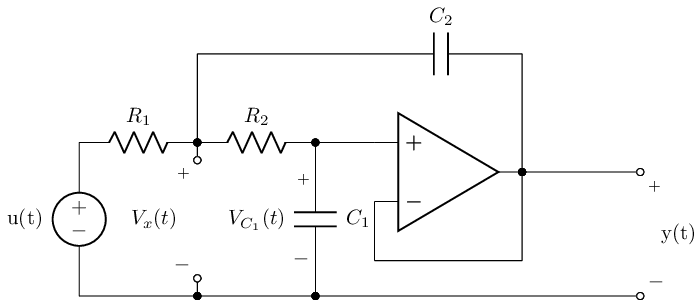

<h3> Onde:                      <ul>                           <li> R1 = 34 $\mathrm{k} \Omega$;</li>                           <li> R2 = 18 $\mathrm{k} \Omega$;</li>                           <li> C1 = 78 $\mathrm{nF}$;</li>                           <li> C2 = 680 $\mathrm{nF}$;</li>                      </ul>                  </h3>

### Para a representação no espaço de estados, as variáveis de estado utilizadas são $V_{C_{1}}(t)$ e                  $V_{x}(t)$.

In [2]:
# Sistema a ser modelado e controlado:

circuito = lcp.Circuit("""
R1 1 2 R1; right, scale=0.8, l^=R_1
R2 2 3 R2; right, scale=0.8, l^=R_2
C1 3 0_3 C1; down, scale=0.8, l^=C_1, v_={V_{C_{1}}(t)}
W 3 3_4; right, size=0.5
E1 6 0_3 opamp 3_4 5_6 oo; scale=0.5, size=0.5, l=
W 5_6 5_8; down, size=0.5
C2 3_1 6_1 C2; right, scale=0.8, l^=C_2
W 6_1 6; down
W 6 6_8; down, size=0.7
W 6_8 5_8; left
W 2 2_1; up=0.75
W 2_1 3_1; right
W 6 7; right
W 0_3 0_7; right
V 1 0 {u(t)}; down, l_={\mathrm{u(t)}}
W 2 2_P1P; down, size=0.15
P1 2_P1P 2_P1N; down, v_=V_{x}(t)
W 2_P1N 0_2; down, size=0.15
W 0_2 0_3; right
W 0 0_2; right
P2 7 0_7; down, v^=y(t)
; draw_nodes=connections, label_ids=none, label_nodes=none""");

# circuito.draw('circuito1.pdf');

display(Markdown('### Para o sistema proposto:'));
display(Markdown('### Determinar a representação do sistema da Figura 1 no espaço de estados, verificando as \
características da planta analógica (resposta transitória).'));
circuito.draw();
display(Markdown('<h3> Onde: \
                     <ul> \
                          <li> R1 = 34 $\mathrm{k} \Omega$;</li> \
                          <li> R2 = 18 $\mathrm{k} \Omega$;</li> \
                          <li> C1 = 78 $\mathrm{nF}$;</li> \
                          <li> C2 = 680 $\mathrm{nF}$;</li> \
                     </ul> \
                 </h3>'));
display(Markdown('### Para a representação no espaço de estados, as variáveis de estado utilizadas são $V_{C_{1}}(t)$ e \
                 $V_{x}(t)$.'));

In [3]:
# Espaço de estados do sistema:

R1 = sp.symbols('R1', positive=True);
R2 = sp.symbols('R2', positive=True);
C1 = sp.symbols('C1', positive=True);
C2 = sp.symbols('C2', positive=True);

A = sp.Matrix([[-1/(R2*C1), 1/(R2*C1)],[(C1-C2)/(R2*C1*C2),(R1*C2-R1*C1-R2*C1)/(R1*R2*C1*C2)]]);
B = sp.Matrix([[0],[1/(R1*C2)]]);
C = sp.Matrix([[1, 0]]);
D = sp.Matrix([0]);

display(Markdown('### Vetor de estados:'));
display(Latex('$ \mathbf{x} = \\left[\\begin{matrix}V_{C_{1}}(t)\\\\V_{x}(t)\\end{matrix}\\right]$'));
display(Markdown('### Matriz de estados:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(A))+'$'));
display(Markdown('### Matriz de entrada:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(B))+'$'));
display(Markdown('### Matriz de saída:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(C))+'$'));
display(Markdown('### Matriz de transmissão direta:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(D))+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \mathbf{\dot{x}} = '+str(sp.latex(A))+'\mathbf{x}+'+str(sp.latex(B))+'u(t)$'));
display(Latex('$y = '+str(sp.latex(C))+'\mathbf{x}$'));

### Vetor de estados:

<IPython.core.display.Latex object>

### Matriz de estados:

<IPython.core.display.Latex object>

### Matriz de entrada:

<IPython.core.display.Latex object>

### Matriz de saída:

<IPython.core.display.Latex object>

### Matriz de transmissão direta:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
# Substituição de valores no espaço de estados do sistema:

defs = {R1: 34e3, R2 : 18e3, C1 : 78e-9, C2 : 680e-9};

A = A.subs(defs);
B = B.subs(defs);
C = C.subs(defs);
D = D.subs(defs);

display(Markdown('### Vetor de estados:'));
display(Latex('$ \mathbf{x} = \\left[\\begin{matrix}V_{C_{1}}(t)\\\\V_{x}(t)\\end{matrix}\\right]$'));
display(Markdown('### Matriz de estados:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(A)).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(B)).replace('.',',')+'$'));
display(Markdown('### Matriz de saída:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(C)).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(D)).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \mathbf{\dot{x}} = '+str(sp.latex(A)).replace('.',',')+
              '\mathbf{x}+'+str(sp.latex(B)).replace('.',',')+'u(t)$'));
display(Latex('$y = '+str(sp.latex(C)).replace('.',',')+'\mathbf{x}$'));

### Vetor de estados:

<IPython.core.display.Latex object>

### Matriz de estados:

<IPython.core.display.Latex object>

### Matriz de entrada:

<IPython.core.display.Latex object>

### Matriz de saída:

<IPython.core.display.Latex object>

### Matriz de transmissão direta:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
# Especificações do sistema original e do sistema controlado:

NT = len('GustavoViannaFrança');
NP = len('Gustavo');

s = sp.symbols('s');

ess = 1 + ((C*(A)**-1)*B)[0];

A = np.matrix(A.tolist(), dtype=np.float64);
B = np.matrix(B.tolist(), dtype=np.float64);
C = np.matrix(C.tolist(), dtype=np.float64);
D = np.matrix(D.tolist(), dtype=np.float64);

# Equação característica do sistema.

autovalores = LA.eig(A)[0];
eq_sistema = root2poly(s, *autovalores);

# Coeficientes do sistema.

wn = math.sqrt(eq_sistema.coeff(s, 0));
zeta = eq_sistema.coeff(s, 1)/(2*wn);
Mp = math.e**(-(math.pi*zeta)/math.sqrt(1-zeta**2));
ts5 = 3/(wn*zeta);

display(Markdown('## Especificações do sistema original:'));
display(Markdown('### Equação característica do sistema:'));
display(Latex('$ EC(s) = '+str(sp.latex(eq_sistema)).replace('.',',')+'$'));
display(Markdown('### Polos do sistema:'));
display(Markdown('$ \mathbf{\mu} = '+str(list(autovalores)).replace(',','; \ ').replace('.',',')+'$'));
display(Markdown('### Frequência natural:'));
display(Latex('$ \omega_{n} = '+str(wn).replace('.',',')+'\, \mathrm{rad/s}$'));
display(Markdown('### Fator de amortecimento:'));
display(Latex('$ \zeta = '+str(zeta).replace('.',',')+'$'));
display(Markdown('### Sobressinal:'));
display(Latex('$ M_{p\%} = '+str(Mp*100).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5%:'));
display(Latex('$ t_{s5\%} = '+str(ts5).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário:'));
display(Latex('$ e(\infty) = '+str(sp.latex(ess)).replace('.',',')+'$'));
display(Markdown('## Especificações do sistema controlado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(2*NP).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% desejado:'));
display(Latex('$ t_{s5\%} = '+str(NT*1e-3).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));
display(Markdown('### Variação máxima do sinal de controle desejada:'));
display(Latex('$u(t) \ \mathrm{de \ 0 \, V \ até \ 3 \, V}$'));

## Especificações do sistema original:

### Equação característica do sistema:

<IPython.core.display.Latex object>

### Polos do sistema:

$ \mathbf{\mu} = [(-62,47597078046908+164,0226959337753j); \  (-62,47597078046908-164,0226959337753j)]$

### Frequência natural:

<IPython.core.display.Latex object>

### Fator de amortecimento:

<IPython.core.display.Latex object>

### Sobressinal:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5%:

<IPython.core.display.Latex object>

### Erro para um degrau unitário:

<IPython.core.display.Latex object>

## Especificações do sistema controlado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% desejado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle desejada:

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau unitário do sistema original:

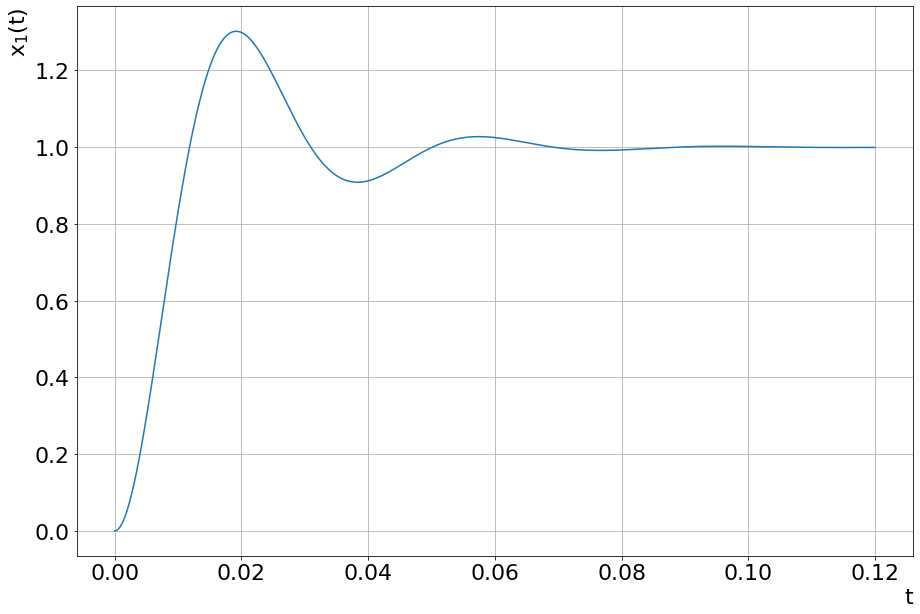

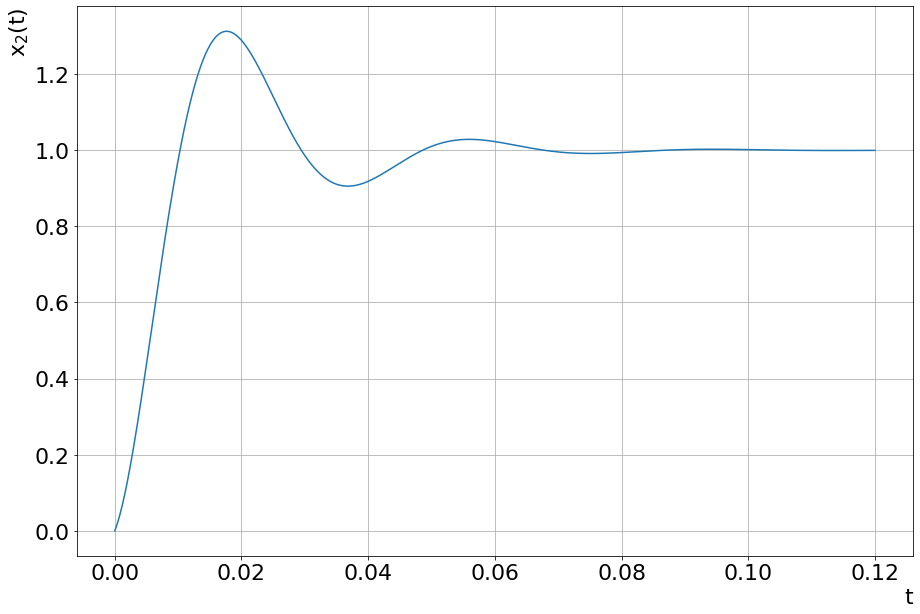

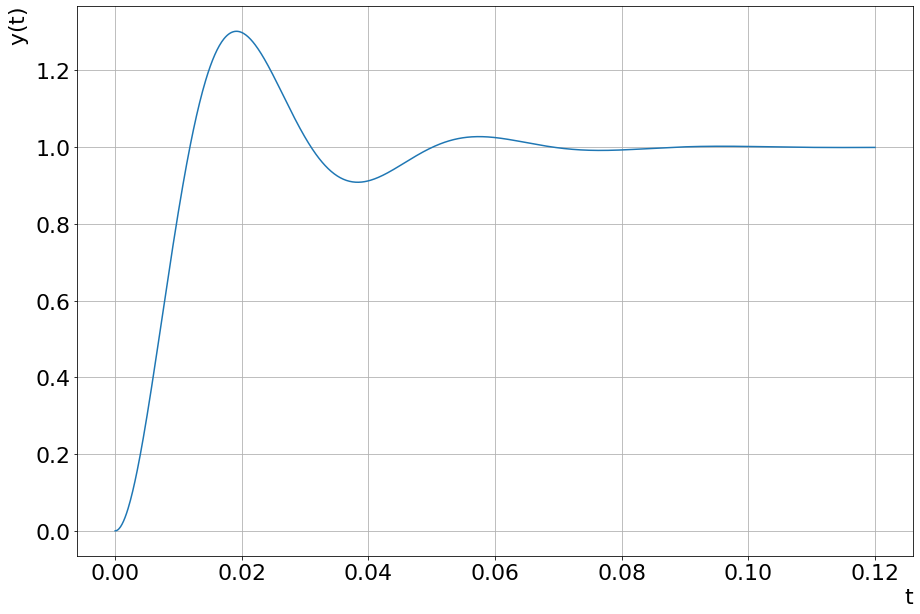

In [6]:
# Simulação do sistema original:

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema de espaço de estados.

sys = ctrl.ss(A,B,C,D);

# Condições Iniciais.

x0 = np.matrix([[0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 120e-3, 1000);
u = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, u, t, x0);

# Comportamento da variável de estado x1(t).

plt.figure();
plt.plot(t, X.T[0]);
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da variável de estado x2(t).

plt.figure();
plt.plot(t, X.T[1]);
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da saída y(t).

plt.figure();
plt.plot(t, Y);
plt.xlabel("t");
plt.ylabel("$\mathrm{y(t)}$");
plt.grid();
plt.tight_layout();
plt.show();

In [7]:
# Especificações do sistema original:

# Tempo de acomodação de 5% para resposta 'contínua':

ts = settling_time(Y, t, 0.05);
    
display(Markdown('## Especificações do sistema simulado:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% obtido:'));
display(Latex('$ t_{s5\%} = '+str(ts).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(relative_error(amplitude, Y[-1])/100).replace('.',',')+'$'));
display(Markdown('## Especificações do sistema calculado:'));
display(Markdown('### Sobressinal calculado:'));
display(Latex('$ M_{p\%} = '+str(Mp*100).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% calculado:'));
display(Latex('$ t_{s5\%} = '+str(ts5).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário calculado:'));
display(Latex('$ e(\infty) = '+str(ess).replace('.',',')+'$'));

## Especificações do sistema simulado:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% obtido:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

## Especificações do sistema calculado:

### Sobressinal calculado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% calculado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário calculado:

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau de 1,5 V do sistema original:

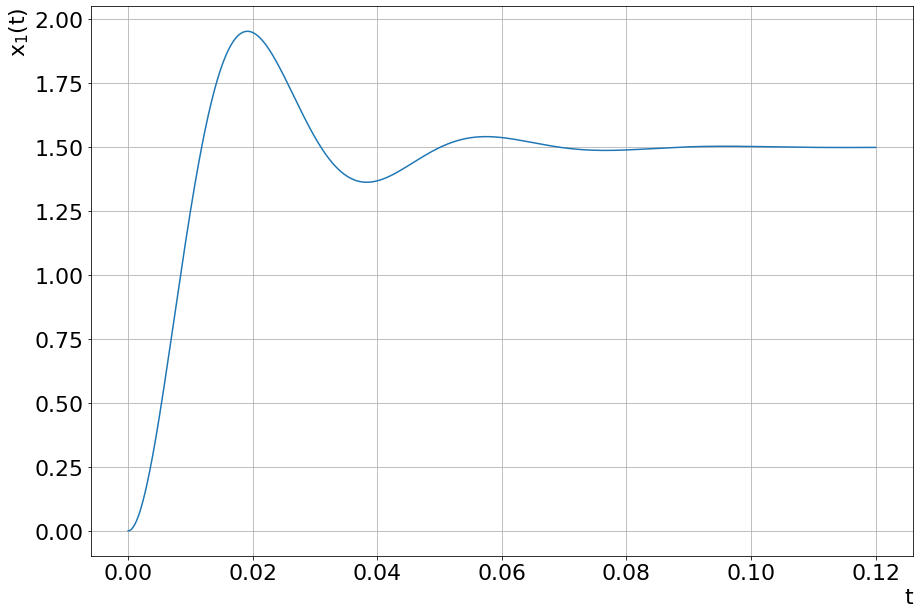

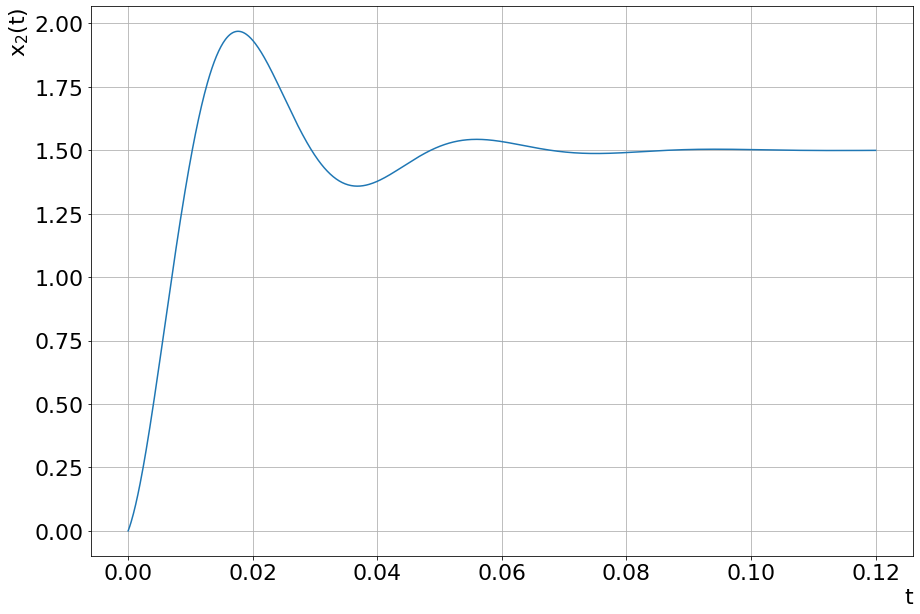

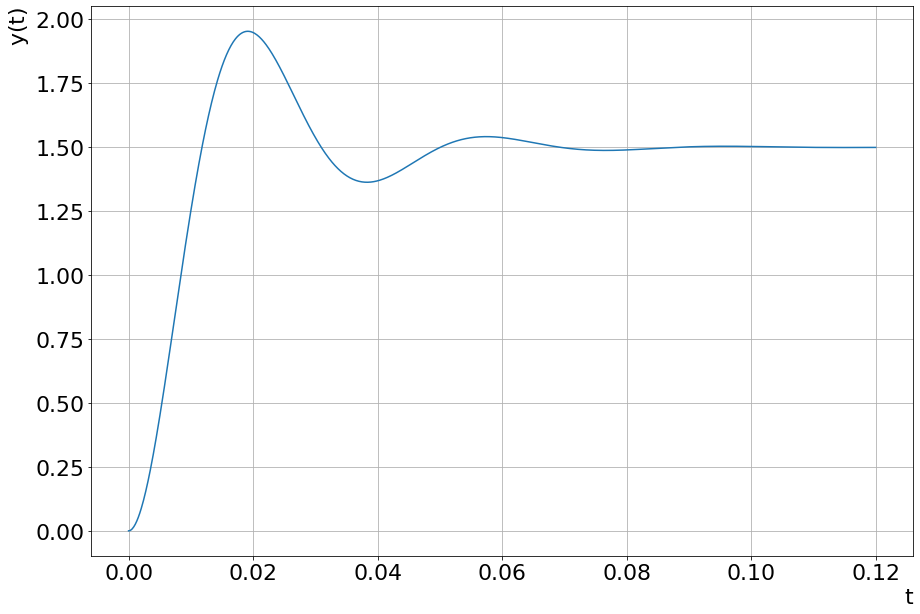

In [8]:
# Simulação do sistema original:

# Amplitude do degrau de entrada.

amplitude = 1.5;

# Sistema de espaço de estados.

sys = ctrl.ss(A,B,C,D);

# Condições Iniciais.

x0 = np.matrix([[0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 120e-3, 1000);
u = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, u, t, x0);

# Comportamento da variável de estado x1(t).

plt.figure();
plt.plot(t, X.T[0]);
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da variável de estado x2(t).

plt.figure();
plt.plot(t, X.T[1]);
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da saída y(t).

plt.figure();
plt.plot(t, Y);
plt.xlabel("t");
plt.ylabel("$\mathrm{y(t)}$");
plt.grid();
plt.tight_layout();
plt.show();

In [9]:
# Especificações do sistema original:

# Tempo de acomodação de 5% para resposta 'contínua':

ts = settling_time(Y, t, 0.05);
    
display(Markdown('## Especificações do sistema simulado:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% obtido:'));
display(Latex('$ t_{s5\%} = '+str(ts).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(relative_error(amplitude, Y[-1])/100).replace('.',',')+'$'));
display(Markdown('## Especificações do sistema calculado:'));
display(Markdown('### Sobressinal calculado:'));
display(Latex('$ M_{p\%} = '+str(Mp*100).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% calculado:'));
display(Latex('$ t_{s5\%} = '+str(ts5).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário calculado:'));
display(Latex('$ e(\infty) = '+str(ess).replace('.',',')+'$'));

## Especificações do sistema simulado:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% obtido:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

## Especificações do sistema calculado:

### Sobressinal calculado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% calculado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário calculado:

<IPython.core.display.Latex object>

# 2. Projeto do controlador por um servossistema:

In [10]:
# Avaliação da controlabilidade do espaço de estados do sistema:

# Matriz de Controlabilidade

Mc = np.block([[A, B],[-C, 0]]);

display(Markdown('### Matrix de controlabilidade:'));
display(Latex('$ \mathbf{M_{c}} = '+str(sp.latex(sp.Matrix(Mc))).replace('.',',')+' $'));
display(Markdown('### Posto da matriz de controlabilidade:'));
display(Latex('$ \mathrm{posto} \, (\mathbf{M_{c}}) = '+str(np.linalg.matrix_rank(Mc))+' $'));
display(Markdown('### O sistema é de estados completamente controláveis.'));

### Matrix de controlabilidade:

<IPython.core.display.Latex object>

### Posto da matriz de controlabilidade:

<IPython.core.display.Latex object>

### O sistema é de estados completamente controláveis.

In [11]:
# Autovalores desejados:

wn = 96*np.pi;
zeta = 0.67;

autovalores = [-zeta*wn+1j*wn*math.sqrt(1-zeta**2), -zeta*wn-1j*wn*math.sqrt(1-zeta**2), -5*zeta*wn];

# Matrizes expandidas:

A_servo = np.block([[A, np.zeros_like(C.T)],[-C, 0]]);
B_servo = np.block([[B],[0]]);

# Matriz de ganhos do controlador K_servo = [k1 k2 -ki]:

K_servo = ctrl.acker(A_servo, B_servo, autovalores);
autovalores_servo = LA.eig(A_servo-B_servo*K_servo)[0];

display(Markdown('### Matriz de estados expandida:'));
display(Latex('$ \mathbf{\hat{A}} = '+str(sp.latex(sp.Matrix(A_servo))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada expandida:'));
display(Latex('$ \mathbf{\hat{B}} = '+str(sp.latex(sp.Matrix(B_servo))).replace('.',',')+'$'));
display(Markdown('### Matriz de realimentação de estados expandida:'));
display(Latex('$ \mathbf{\hat{K}} = '+str(sp.latex(sp.Matrix(K_servo))).replace('.',',')+'$'));
display(Markdown('### Autovalores desejados:'));
display(Markdown('$ \mathbf{\mu} = '+str(autovalores).replace(',','; \ ').replace('.',',')+'$'));
display(Markdown('### Polinômio característico desejado:'));
display(Latex('$ EC(s) = '+str(sp.latex(root2poly(s, *autovalores))).replace('.', ',')+'$'))
display(Markdown('### Autovalores obtidos:'));
display(Latex('$ \mathbf{\hat{\mu}} = '+str(list(autovalores_servo)).replace(',','; \ ').replace('.',',')+'$'));

### Matriz de estados expandida:

<IPython.core.display.Latex object>

### Matriz de entrada expandida:

<IPython.core.display.Latex object>

### Matriz de realimentação de estados expandida:

<IPython.core.display.Latex object>

### Autovalores desejados:

$ \mathbf{\mu} = [(-202,06723947889552+223,89083252741327j); \  (-202,06723947889552-223,89083252741327j); \  -1010,3361973944775]$

### Polinômio característico desejado:

<IPython.core.display.Latex object>

### Autovalores obtidos:

<IPython.core.display.Latex object>

In [12]:
# Matriz de controlabilidade do servossistema:

M = np.block([B_servo, A_servo*B_servo, (A_servo**2)*B_servo]);

# Equação característica desejada:

s, I = sp.symbols('s I');

eq_des = root2poly(s, *autovalores);

# Substituição da matriz A no polinômio desejado phi(A):

ordem = sp.degree(eq_des);
eq_tmp = eq_des - eq_des.coeff(s, 0) + eq_des.coeff(s,0)*I;
eq_tmp = eq_tmp.xreplace({I : sp.Matrix(np.eye(ordem))});

phi = sp.lambdify(s, eq_tmp, 'numpy');

# Fórmula de Ackreman:

k = np.array([[*np.zeros(ordem)]]);
k[0][-1] = 1;
K1 = k*LA.inv(M)*phi(A_servo);

display(Markdown('### Matriz de controlabilidade expandida:'));
display(Latex('$ \mathbf{M} = '+str(sp.latex(sp.Matrix(M))).replace('.',',')+'$'))
display(Markdown('### Matriz $\phi(\mathbf{\hat{A}})$:'));
display(Latex('$ \phi(\mathbf{\hat{A}}) = '+str(sp.latex(sp.Matrix(phi(A_servo)))).replace('.',',')+'$'))
display(Markdown('### Matriz de realimentação de estados expandida:'));
display(Latex('$ \mathbf{\hat{K}} = '+str(sp.latex(sp.Matrix(K1))).replace('.',',')+'$'))

### Matriz de controlabilidade expandida:

<IPython.core.display.Latex object>

### Matriz $\phi(\mathbf{\hat{A}})$:

<IPython.core.display.Latex object>

### Matriz de realimentação de estados expandida:

<IPython.core.display.Latex object>

In [13]:
K = K_servo.tolist()[0];
K = np.matrix([k for k in K[0:len(K)-1]]);
ki = -(K_servo.tolist()[0][-1]);
AA = np.block([[A-B*K, B*ki],[-C, 0]]);
BB = np.matrix(np.array([[*np.zeros(len(autovalores))]]).T);
BB[-1] = 1;
CC = np.matrix(C.tolist()[0]+[float(0)]);
DD = np.matrix([float(0)]);

display(Markdown('### Matriz de estados expandida:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(sp.Matrix(AA))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada expandida:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(sp.Matrix(BB))).replace('.',',')+'$'));
display(Markdown('### Matriz de saída expandida:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta expandida:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(sp.Matrix(DD))).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \\left[\\begin{matrix} \\mathbf{\\dot{x}} (t) \\\\ \\dot{\\xi} (t) \\end{matrix}\\right] = '+
              str(sp.latex(sp.Matrix(AA))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\end{matrix}\\right]+'+
              str(sp.latex(sp.Matrix(BB))).replace('.',',')+'r(t)$'));
display(Latex('$y = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\end{matrix}\\right]$'));

### Matriz de estados expandida:

<IPython.core.display.Latex object>

### Matriz de entrada expandida:

<IPython.core.display.Latex object>

### Matriz de saída expandida:

<IPython.core.display.Latex object>

### Matriz de transmissão direta expandida:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau unitário do sistema controlado:

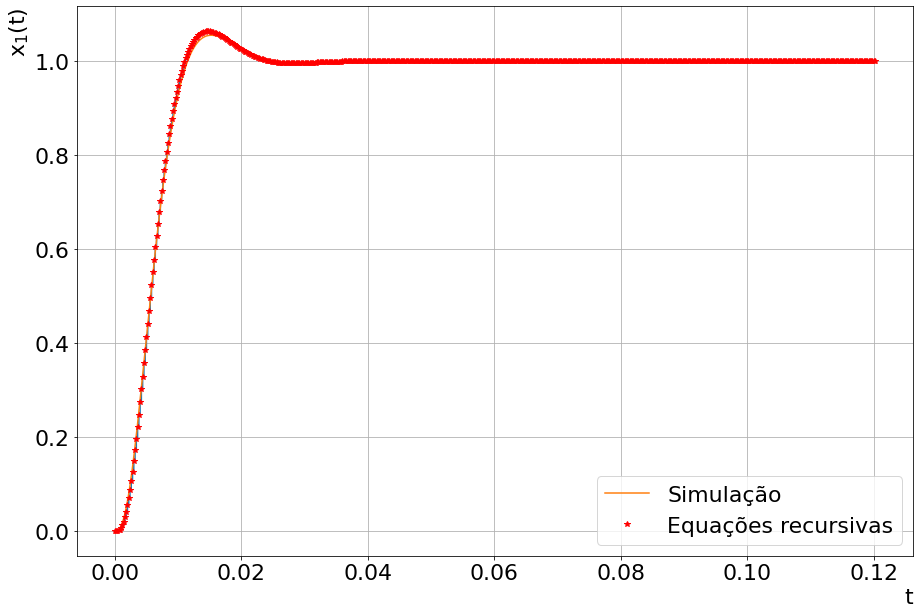

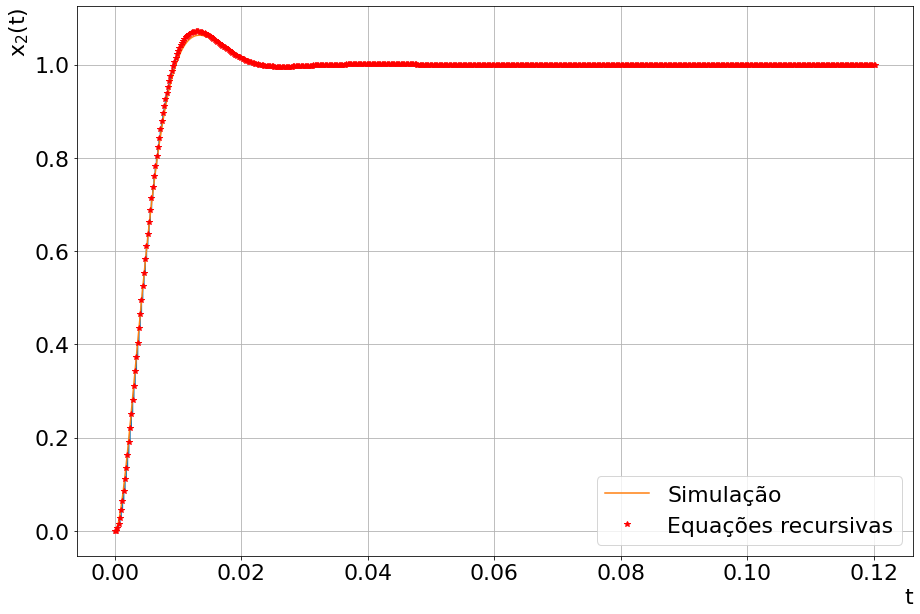

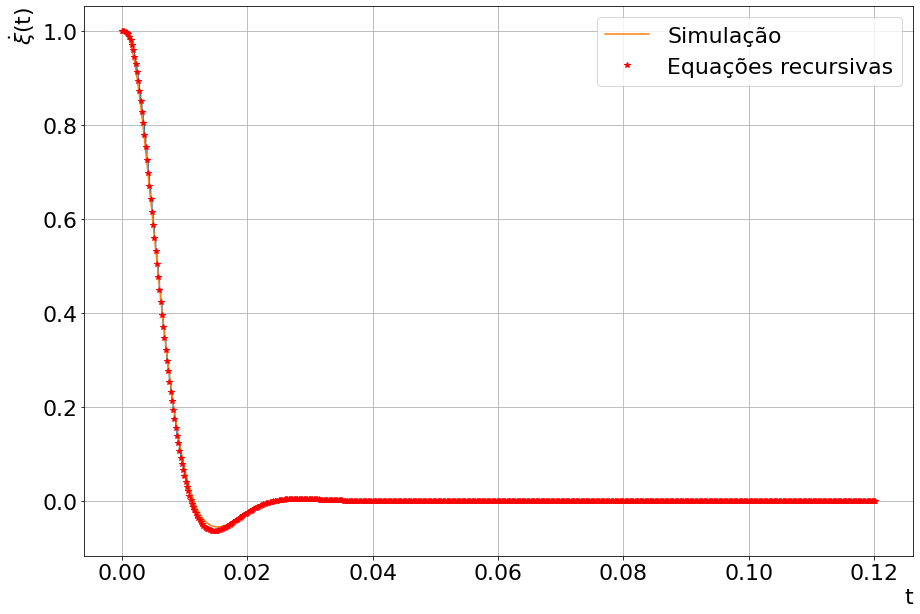

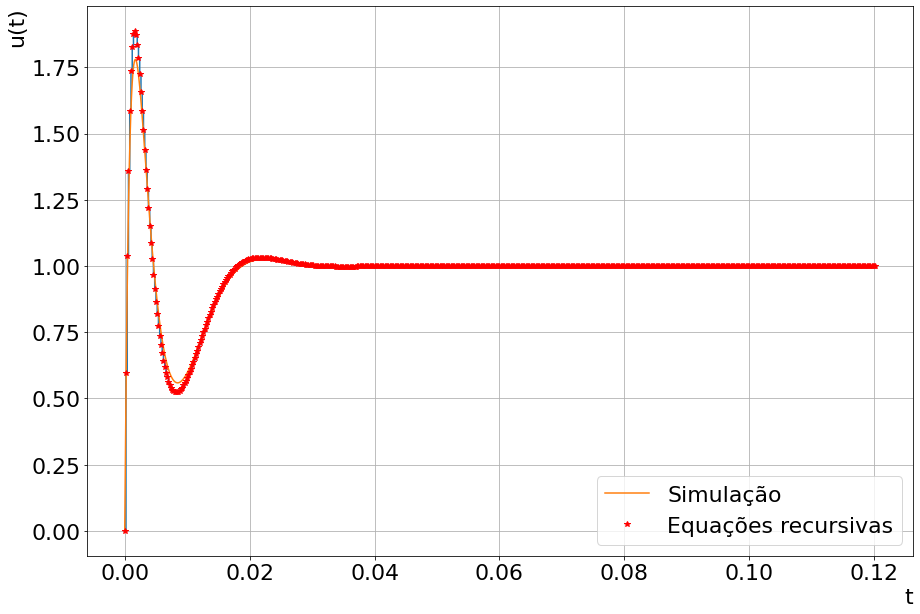

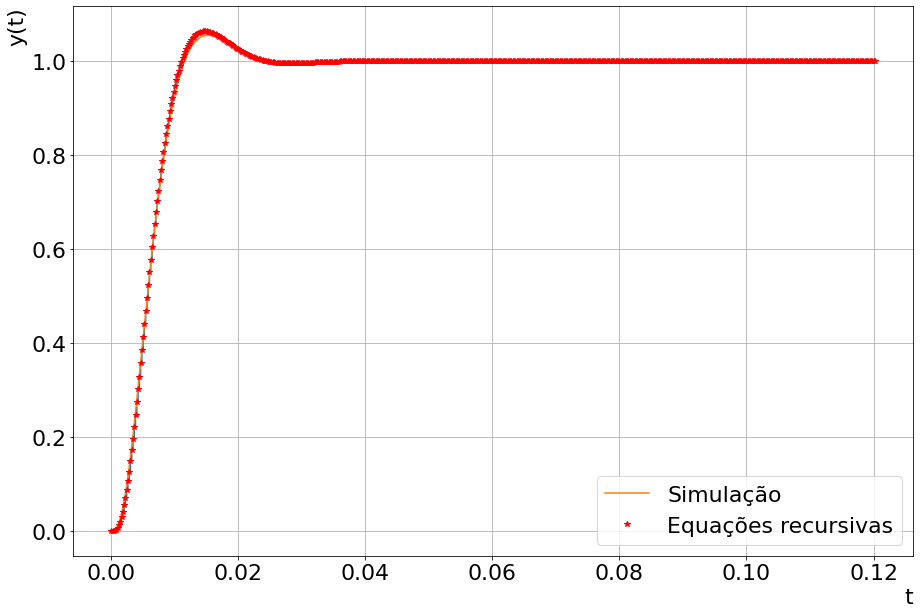

In [14]:
# Simulação do sistema controlado 'contínuo' e discreto com amplitude de 1,0 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema expandido.

sistema_servo = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 120e-3, 1000);
R = amplitude*np.heaviside(t,1);
Y, t, X = ctrl.matlab.lsim(sistema_servo, R, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)=E(z)/E_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)
# e(k)=T*e_ponto(k-1)+e(k-1)

T = 2e-4;
tfinal = 120e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
r = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
qsi = np.zeros_like(k);
u = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
erro = np.zeros_like(k);
y = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
qsi[0] = x0[2];  #  para k = 0
u[0] = -(K[0,0]*x1[0]+K[0,1]*x2[0])+ki*qsi[0];
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
erro[0] = r[0]-y[0];  #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];    
    qsi[j] = T*erro[j-1]+qsi[j-1];
    
    # Equação da diferença do sinal de controle:
    
    u[j] = -(K[0,0]*x1[j]+K[0,1]*x2[j])+ki*qsi[j];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
    
    # Equação diferencial do erro: Eponto=R-Y
    
    erro[j] = r[j]-y[j];
    
# Equação do sinal de controle 'contínuo':

U = np.zeros_like(t);
for j in range(len(t)):
    U[j] = -(K[0,0]*X1a[j]+K[0,1]*X1b[j])+ki*X1c[j];
    
# Equação do erro do sistema 'contínuo':    

E = np.zeros_like(t);
for j in range(len(t)):
    E[j] = R[j] - Y[j];
    
    
# Comportamento do estado x1:
plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2:      
plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída do erro:                       
plt.figure();
plt.plot(k*T, erro, ds='steps-post');
plt.plot(t, E, label='Simulação');
plt.plot(k*T, erro, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\\dot{\\xi}$(t)");
plt.legend(loc='upper right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da ação de controle:                       
plt.figure();
plt.plot(k*T, u, ds='steps-post');
plt.plot(t, U, label='Simulação');
plt.plot(k*T, u, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("u(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y:
plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y, label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

In [15]:
# Especificações do sistema controlado:

# Tempo de acomodação de 5% para resposta ao degrau unitário:

ts = [];

ts.append(settling_time(Y, t, 0.05));
ts.append(settling_time(y, T*k, 0.05));

display(Markdown('## Especificações da simulação do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% obtido:'));
display(Latex('$ t_{s5\%} = '+str(ts[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(E[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(U)).replace('.',',')+' \, V \ até \ '+
              str(max(U)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% obtido:'));
display(Latex('$ t_{s5\%} = '+str(ts[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(erro[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(u)).replace('.',',')+' \, V \ até \ '+
              str(max(u)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações do sistema desejado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(2*NP).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% desejado:'));
display(Latex('$ t_{s5\%} = '+str(NT*1e-3).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));
display(Markdown('### Variação máxima do sinal de controle desejada:'));
display(Latex('$u(t) \ \mathrm{de \ 0 \, V \ até \ 3 \, V}$'));

## Especificações da simulação do sistema controlado para um degrau unitário:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% obtido:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% obtido:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações do sistema desejado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% desejado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle desejada:

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau de 1,5 V do sistema controlado:

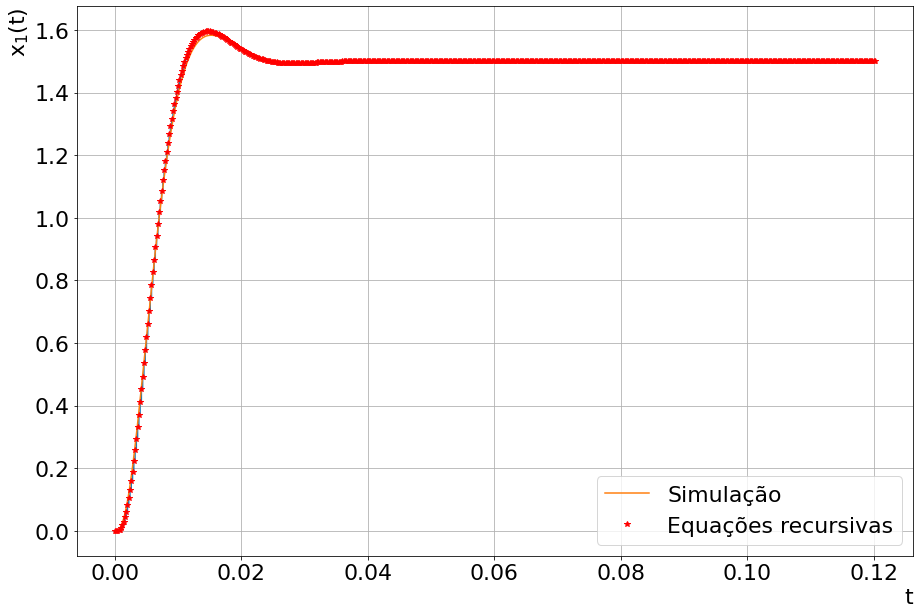

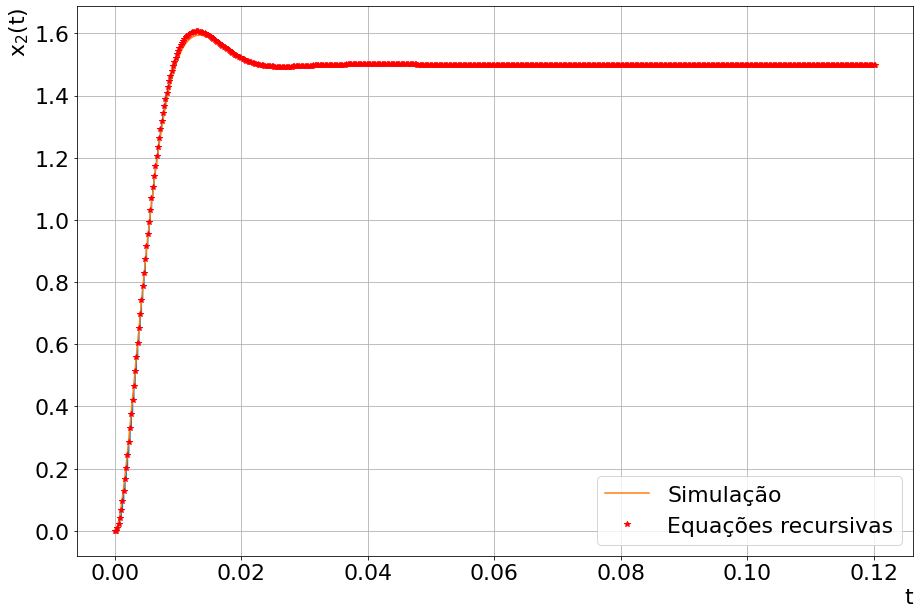

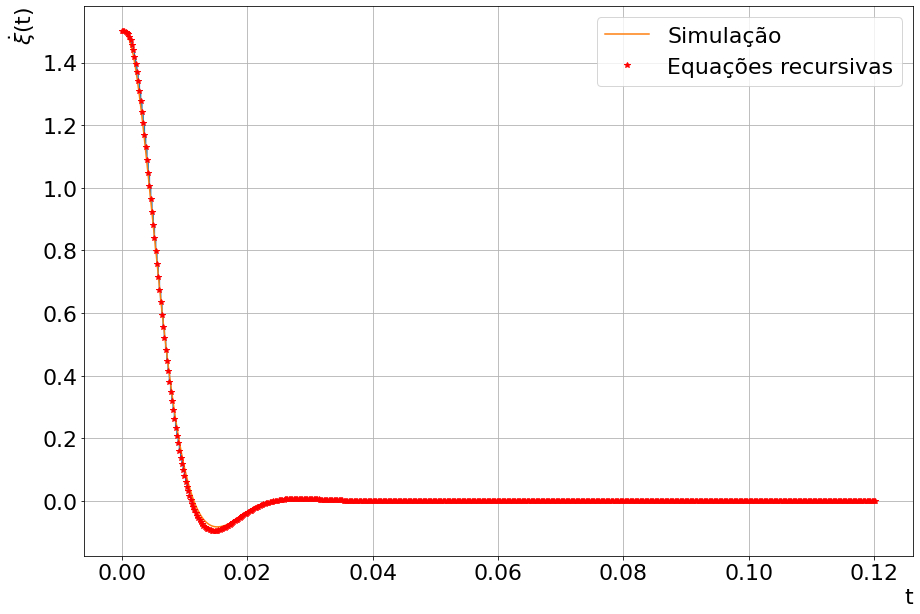

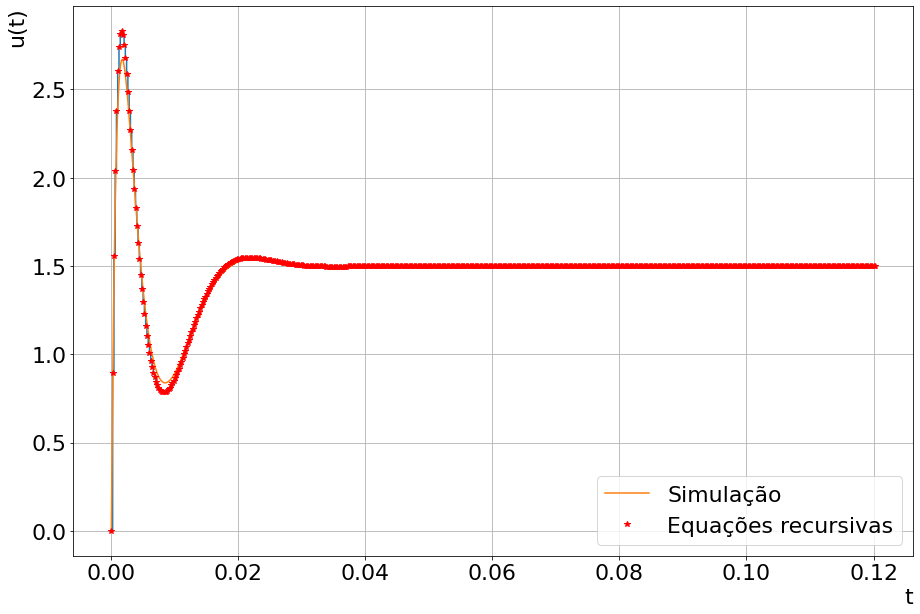

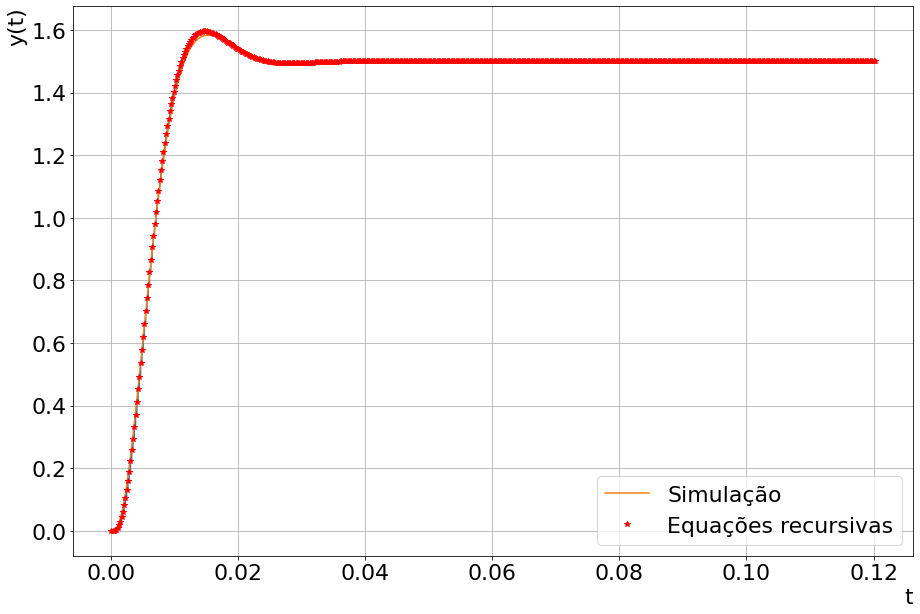

In [16]:
# Simulação do sistema controlado 'contínuo' e discreto com amplitude de 1,5 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.5;

# Sistema expandido.

sistema_servo = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 120e-3, 1000);
R = amplitude*np.heaviside(t,1);
Y, t, X = ctrl.matlab.lsim(sistema_servo, R, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)=E(z)/E_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)
# e(k)=T*e_ponto(k-1)+e(k-1)

T = 2e-4;
tfinal = 120e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
r = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
qsi = np.zeros_like(k);
u = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
erro = np.zeros_like(k);
y = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
qsi[0] = x0[2];  #  para k = 0
u[0] = -(K[0,0]*x1[0]+K[0,1]*x2[0])+ki*qsi[0];
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
erro[0] = r[0]-y[0];  #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];    
    qsi[j] = T*erro[j-1]+qsi[j-1];
    
    # Equação da diferença do sinal de controle:
    
    u[j] = -(K[0,0]*x1[j]+K[0,1]*x2[j])+ki*qsi[j];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
    
    # Equação diferencial do erro: Eponto=R-Y
    
    erro[j] = r[j]-y[j];
    
# Equação do sinal de controle 'contínuo':

U = np.zeros_like(t);
for j in range(len(t)):
    U[j] = -(K[0,0]*X1a[j]+K[0,1]*X1b[j])+ki*X1c[j];
    
# Equação do erro do sistema 'contínuo':    

E = np.zeros_like(t);
for j in range(len(t)):
    E[j] = R[j] - Y[j];
    
    
# Comportamento do estado x1:
plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2:      
plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída do erro:                       
plt.figure();
plt.plot(k*T, erro, ds='steps-post');
plt.plot(t, E, label='Simulação');
plt.plot(k*T, erro, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\\dot{\\xi}$(t)");
plt.legend(loc='upper right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da ação de controle:                       
plt.figure();
plt.plot(k*T, u, ds='steps-post');
plt.plot(t, U, label='Simulação');
plt.plot(k*T, u, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("u(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y:
plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y, label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

In [17]:
# Especificações do sistema controlado:

# Tempo de acomodação de 5% para resposta ao degrau unitário:

ts = [];

ts.append(settling_time(Y, t, 0.05));
ts.append(settling_time(y, T*k, 0.05));

display(Markdown('## Especificações da simulação do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% obtido:'));
display(Latex('$ t_{s5\%} = '+str(ts[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(E[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(U)).replace('.',',')+' \, V \ até \ '+
              str(max(U)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% obtido:'));
display(Latex('$ t_{s5\%} = '+str(ts[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(erro[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(u)).replace('.',',')+' \, V \ até \ '+
              str(max(u)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações do sistema desejado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(2*NP).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% desejado:'));
display(Latex('$ t_{s5\%} = '+str(NT*1e-3).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));
display(Markdown('### Variação máxima do sinal de controle desejada:'));
display(Latex('$u(t) \ \mathrm{de \ 0 \, V \ até \ 3 \, V}$'));

## Especificações da simulação do sistema controlado para um degrau unitário:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% obtido:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% obtido:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações do sistema desejado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% desejado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle desejada:

<IPython.core.display.Latex object>

# 3. Projeto do observador de estados:

In [18]:
# Avaliação da observabilidade do espaço de estados do sistema:

# Matriz de Observabilidade

N = ctrl.obsv(A, C).T;

display(Markdown('### Matrix de observabilidade:'));
display(Latex('$ \mathbf{N} = '+str(sp.latex(sp.Matrix(N))).replace('.',',')+' $'));
display(Markdown('### Posto da matriz de observabilidade:'));
display(Latex('$ \mathrm{posto} \, (\mathbf{N}) = '+str(np.linalg.matrix_rank(N))+' $'));
display(Markdown('### O sistema é de estados completamente observáveis.'));

### Matrix de observabilidade:

<IPython.core.display.Latex object>

### Posto da matriz de observabilidade:

<IPython.core.display.Latex object>

### O sistema é de estados completamente observáveis.

In [19]:
# Autovalores desejados:

wn = 96*np.pi;
zeta = 0.67;

autovalores = np.multiply([-zeta*wn+1j*wn*math.sqrt(1-zeta**2), -zeta*wn-1j*wn*math.sqrt(1-zeta**2)], 4);

# Matriz de ganhos do observador Ke:

Ke = ctrl.acker(np.conjugate(A.T), np.conjugate(C.T), autovalores).T;
autovalores_e = LA.eig(A-Ke*C)[0];

display(Markdown('### Matriz de ganhos do observador:'));
display(Latex('$ \mathbf{K_{e}} = '+str(sp.latex(sp.Matrix(Ke))).replace('.',',')+'$'));
display(Markdown('### Autovalores desejados:'));
display(Markdown('$ \mathbf{\mu} = '+str(autovalores).replace(',','; \ ').replace('.',',')+'$'));
display(Markdown('### Polinômio característico desejado:'));
display(Latex('$ EC(s) = '+str(sp.latex(root2poly(s, *autovalores))).replace('.', ',')+'$'))
display(Markdown('### Autovalores obtidos:'));
display(Latex('$ \mathbf{\mu_{e}} = '+str(list(autovalores_e)).replace(',','; \ ').replace('.',',')+'$'));

### Matriz de ganhos do observador:

<IPython.core.display.Latex object>

### Autovalores desejados:

$ \mathbf{\mu} = [-808,26895792+895,56333011j -808,26895792-895,56333011j]$

### Polinômio característico desejado:

<IPython.core.display.Latex object>

### Autovalores obtidos:

<IPython.core.display.Latex object>

In [20]:
# Matriz de observabilidade do servossistema:

N = np.block([np.conjugate(C.T), np.conjugate(A.T)*np.conjugate(C.T)]);

# Equação característica desejada:

s, I = sp.symbols('s I');

eq_des = root2poly(s, *autovalores);

# Substituição da matriz A no polinômio desejado phi(A):

ordem = sp.degree(eq_des);
eq_tmp = eq_des - eq_des.coeff(s, 0) + eq_des.coeff(s,0)*I;
eq_tmp = eq_tmp.xreplace({I : sp.Matrix(np.eye(ordem))});

phi = sp.lambdify(s, eq_tmp, 'numpy');

# Fórmula de Ackreman:

k = np.array([[*np.zeros(ordem)]]);
k[0][-1] = 1;
K2 = (k*LA.inv(N)*phi(np.conjugate(A.T))).T;

display(Markdown('### Matriz de observabilidade:'));
display(Latex('$ \mathbf{N} = '+str(sp.latex(sp.Matrix(N))).replace('.',',')+'$'))
display(Markdown('### Matriz $\phi(\mathbf{A}^{*})$:'));
display(Latex('$ \phi(\mathbf{A}^{*}) = '+str(sp.latex(sp.Matrix(phi(np.conjugate(A.T))))).replace('.',',')+'$'))
display(Markdown('### Matriz de ganho de observadores de estados:'));
display(Latex('$ \mathbf{K}_{e} = '+str(sp.latex(sp.Matrix(K2))).replace('.',',')+'$'))

### Matriz de observabilidade:

<IPython.core.display.Latex object>

### Matriz $\phi(\mathbf{A}^{*})$:

<IPython.core.display.Latex object>

### Matriz de ganho de observadores de estados:

<IPython.core.display.Latex object>

In [21]:
AA = np.block([[A, np.zeros_like(A)],[Ke*C, A-Ke*C]]);
BB = np.block([[B],[B]]);
CC = np.matrix([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]], dtype=np.float64);
DD = np.zeros([2*len(A),1]);

display(Markdown('### Matriz de estados:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(sp.Matrix(AA))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(sp.Matrix(BB))).replace('.',',')+'$'));
display(Markdown('### Matriz de saída:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(sp.Matrix(DD))).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \\left[\\begin{matrix} \\mathbf{\\dot{x}} (t) \\\\ \\mathbf{\\dot{\\tilde{x}}} (t) \\end{matrix}\\right] = '+
              str(sp.latex(sp.Matrix(AA))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\mathbf{\\tilde{x}} (t) \\end{matrix}\\right]+'+
              str(sp.latex(sp.Matrix(BB))).replace('.',',')+'\mathbf{u}(t)$'));
display(Latex('$y = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\mathbf{\\tilde{x}} (t) \\end{matrix}\\right]$'));

### Matriz de estados:

<IPython.core.display.Latex object>

### Matriz de entrada:

<IPython.core.display.Latex object>

### Matriz de saída:

<IPython.core.display.Latex object>

### Matriz de transmissão direta:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau unitário do sistema com o observador de estados:

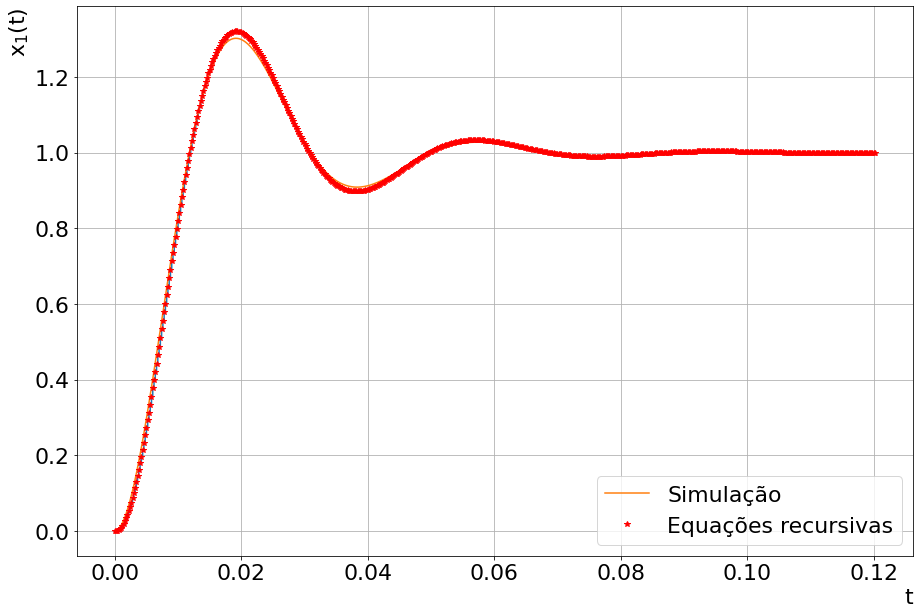

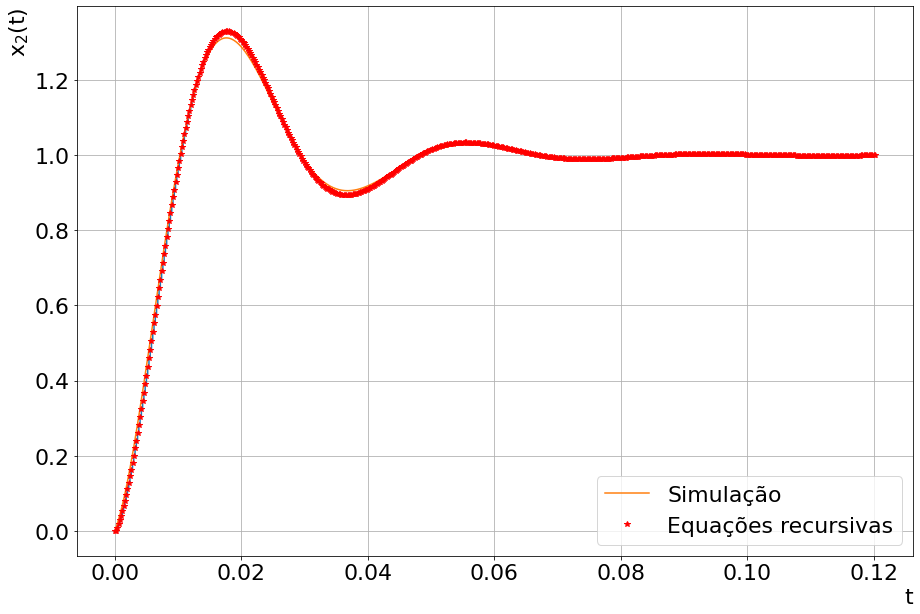

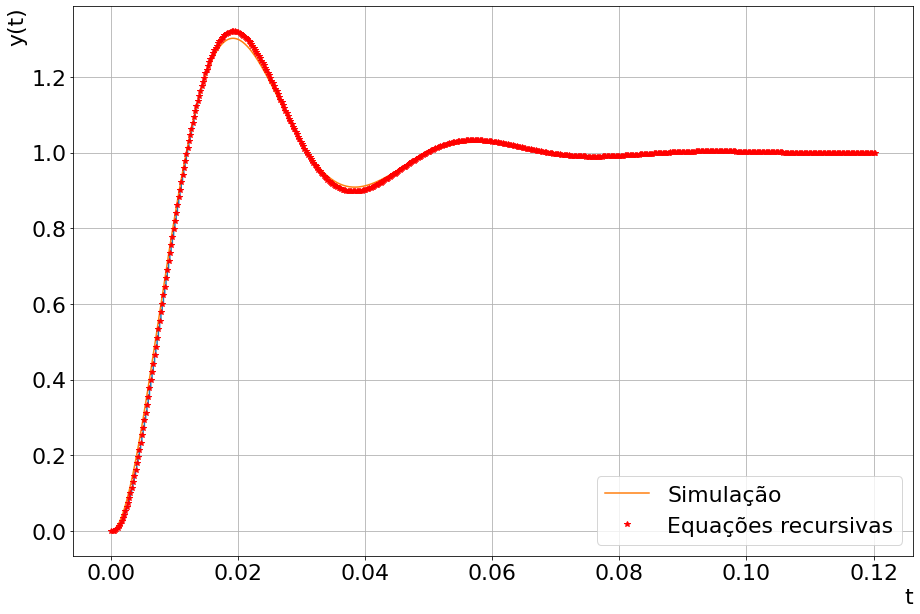

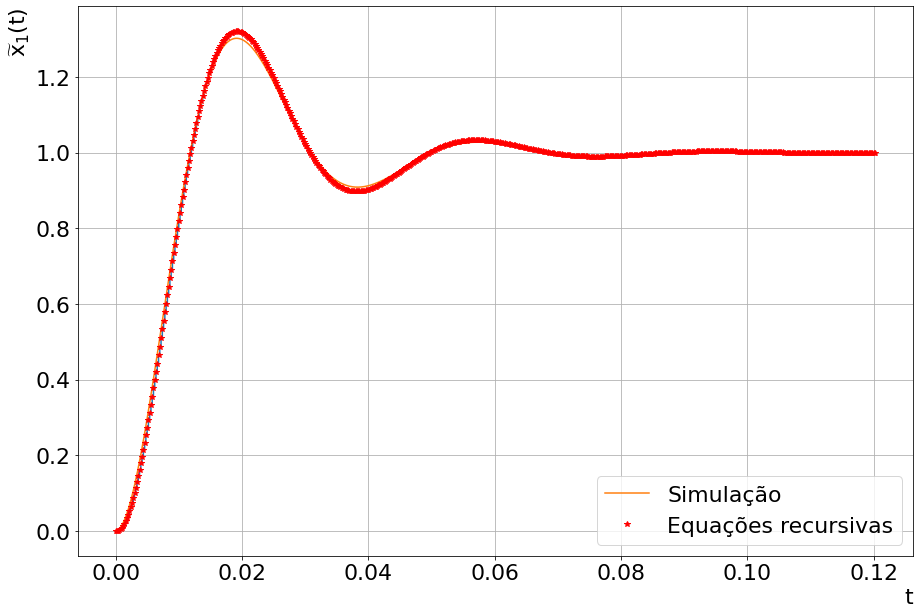

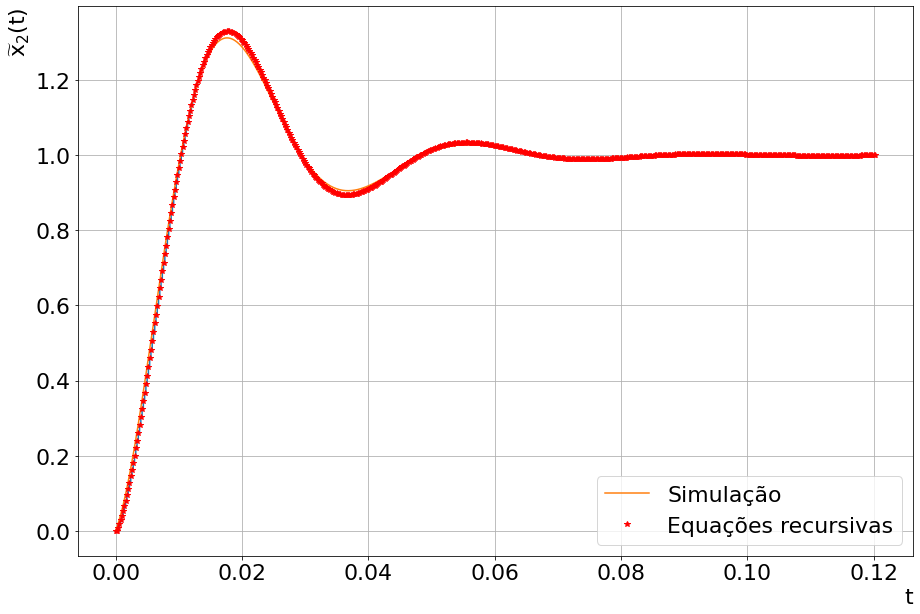

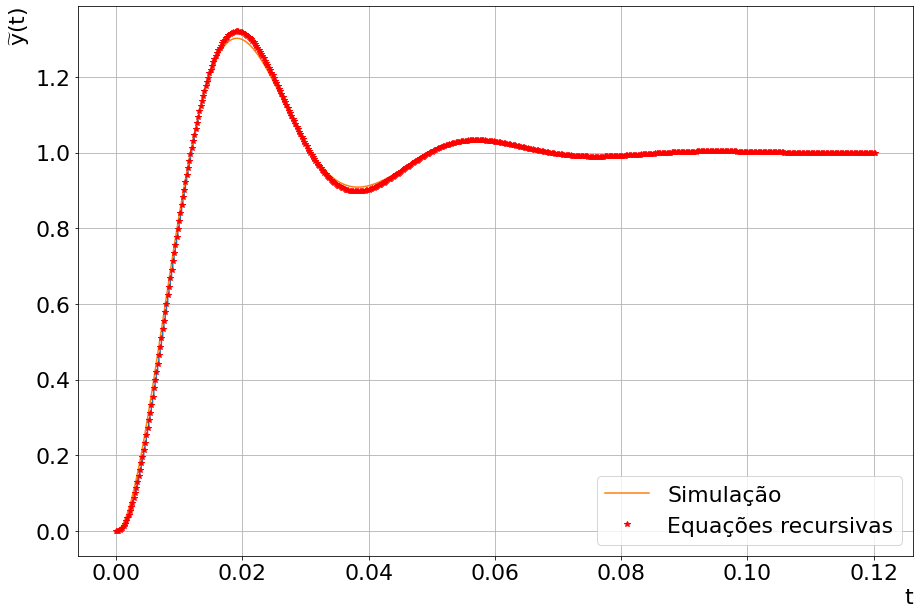

In [22]:
# Simulação do sistema com o observador de estados 'contínuo' e discreto com amplitude de 1,0 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema expandido.

sys = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0], [0]]);

# Simulação do sistema expandido.

t = np.linspace(0, 120e-3, 1000);
U = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, U, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];
X1d = X[:,3];

# Simulação com discretização dos integradores
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)

T = 2e-4;
tfinal = 120e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
u = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x1e = np.zeros_like(k);
x2e = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x1e_ponto = np.zeros_like(k);
x2e_ponto = np.zeros_like(k);
y = np.zeros_like(k);
ye = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = 0;  #  para k = 0
x2[0] = 0;  #  para k = 0
x1e[0] = 0;  #  para k = 0
x2e[0] = 0;  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x1e_ponto[0] = 0;  #  para k = 0
x2e_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
ye[0] = C[0,0]*x1e[0]+C[0,1]*x2e[0]+D*u[0];  #  para k = 0

for j in range(1,Kmax+1):
    
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x1e[j] = T*x1e_ponto[j-1]+x1e[j-1];
    x2e[j] = T*x2e_ponto[j-1]+x2e[j-1];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j];
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
    ye[j] = C[0,0]*x1e[j]+C[0,1]*x2e[j]+D*u[j];
    
    # Equação diferencial de estados aproximados:  Xeponto=A*Xe+B*U+Ke*(Y-Ye)
    
    x1e_ponto[j] = A[0,0]*x1e[j]+A[0,1]*x2e[j]+B[0]*u[j]+Ke[0,0]*(y[j]-ye[j]);  
    x2e_ponto[j] = A[1,0]*x1e[j]+A[1,1]*x2e[j]+B[1]*u[j]+Ke[1,0]*(y[j]-ye[j]);
    
# Comportamento do estado x1:

plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1,'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2:

plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y:

plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y.T[0], label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x1e:

plt.figure();
plt.plot(k*T, x1e, ds='steps-post');
plt.plot(t, X1c, label='Simulação');
plt.plot(k*T, x1e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x2e:

plt.figure();
plt.plot(k*T, x2e, ds='steps-post');
plt.plot(t, X1d, label='Simulação');
plt.plot(k*T, x2e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída ye:

plt.figure();
plt.plot(k*T, ye, ds='steps-post');
plt.plot(t, Y.T[2], label='Simulação');
plt.plot(k*T, ye, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{y}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

In [23]:
# Especificações do sistema com o observador de estados:

# Tempo de acomodação de 5% para resposta 'contínua':

ts = [];

ts.append(settling_time(Y.T[0], t, 0.05));
ts.append(settling_time(Y.T[2], t, 0.05));

# Tempo de acomodação de 5% para resposta discreta:

ts.append(settling_time(y, T*k, 0.05));
ts.append(settling_time(ye, T*k, 0.05));

display(Markdown('## Especificações do sistema simulado:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y.T[0])).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y.T[2])).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('## Especificações do sistema simulado por equações recursivas:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[2]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(ye)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[3]).replace('.',',')+'\, \mathrm{s}$'));

## Especificações do sistema simulado:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

## Especificações do sistema simulado por equações recursivas:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau de 1,5 V do sistema com o observador de estados:

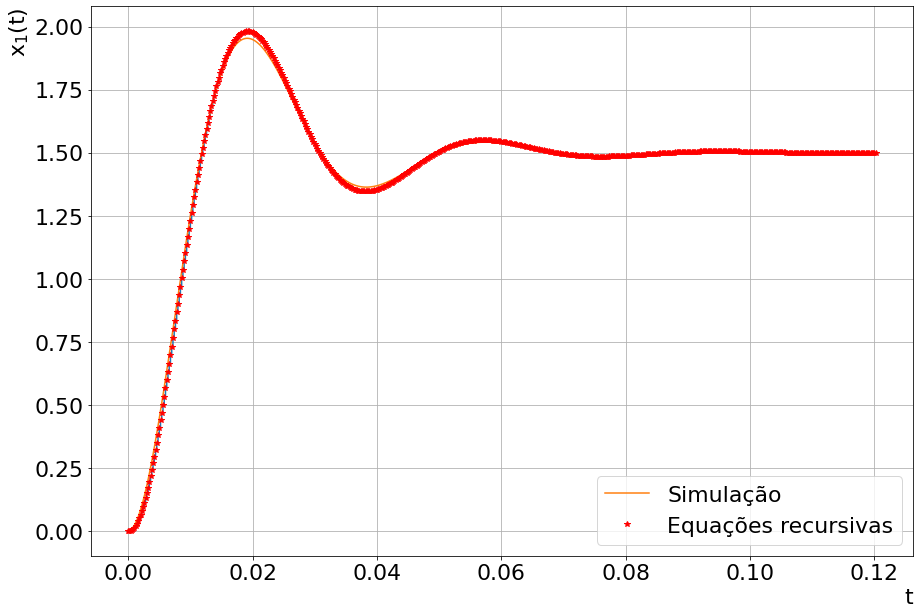

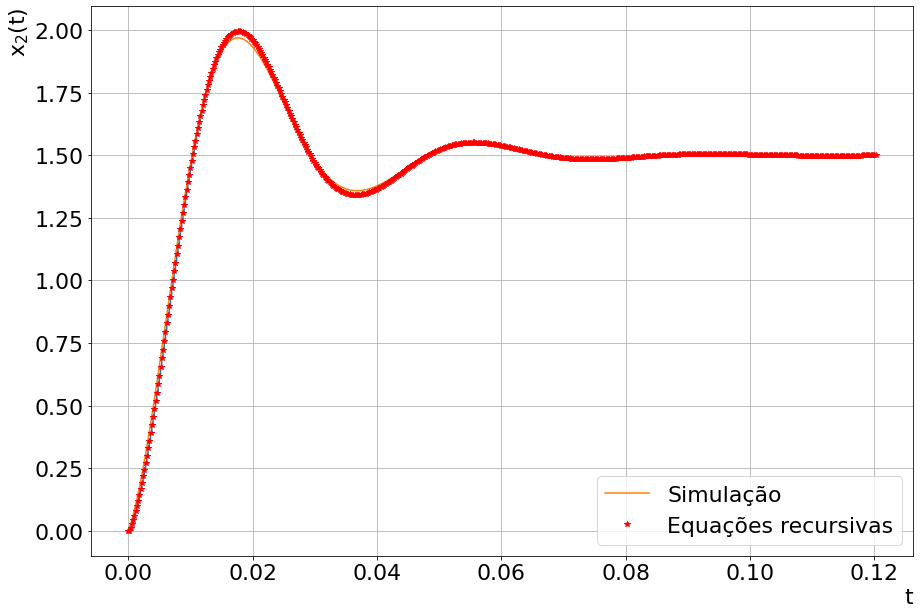

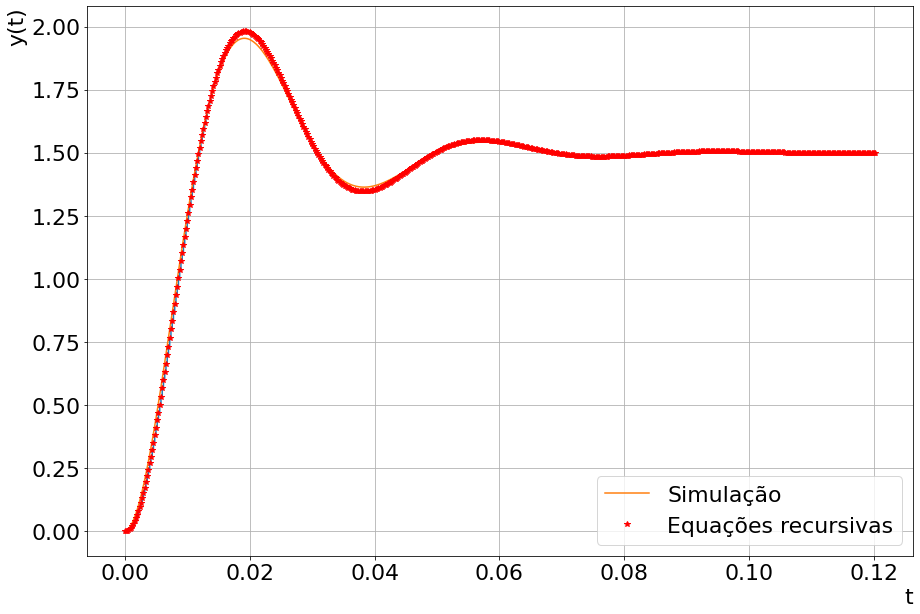

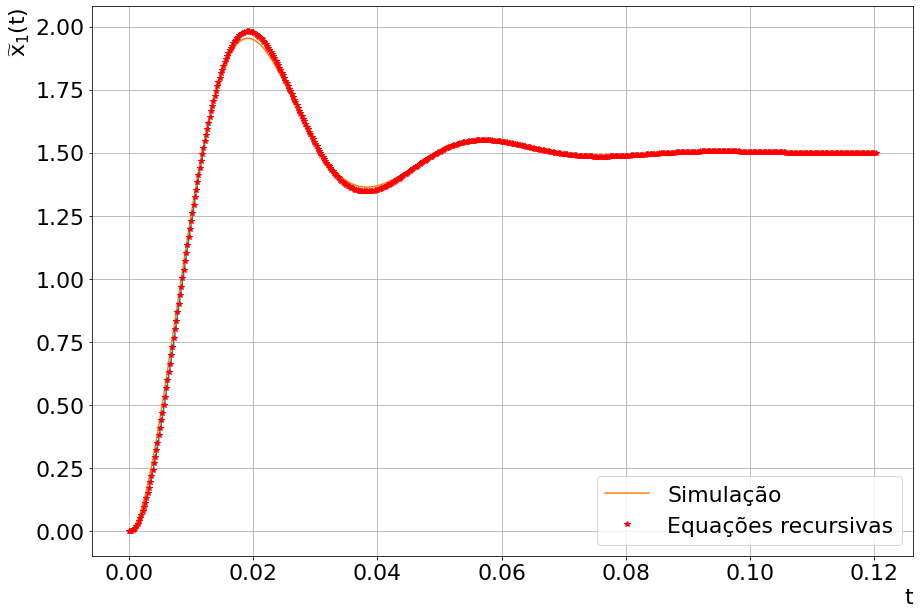

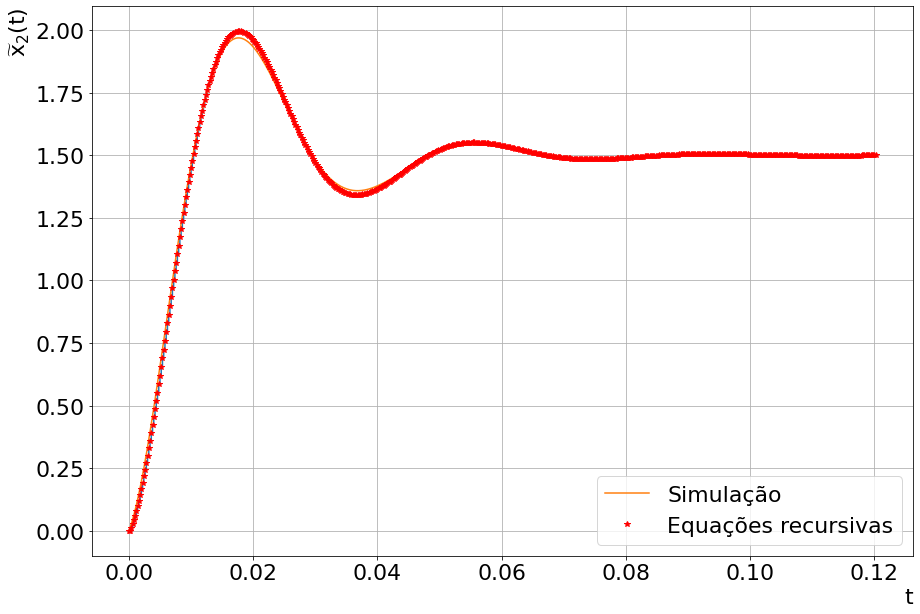

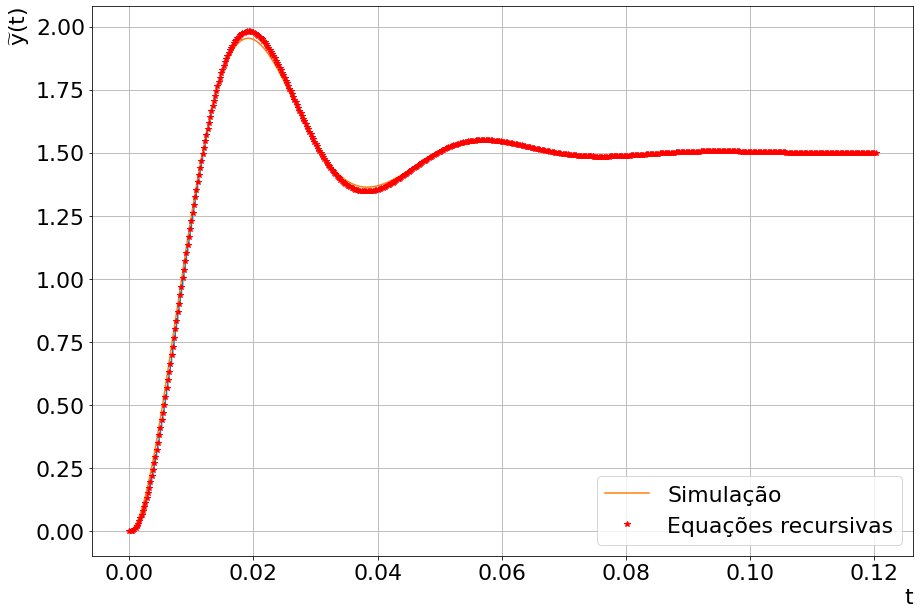

In [24]:
# Simulação do sistema com o observador de estados 'contínuo' e discreto com amplitude de 1,5 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.5;

# Sistema expandido.

sys = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0], [0]]);

# Simulação do sistema expandido.

t = np.linspace(0, 120e-3, 1000);
U = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, U, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];
X1d = X[:,3];

# Simulação com discretização dos integradores
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)

T = 2e-4;
tfinal = 120e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
u = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x1e = np.zeros_like(k);
x2e = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x1e_ponto = np.zeros_like(k);
x2e_ponto = np.zeros_like(k);
y = np.zeros_like(k);
ye = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = 0;  #  para k = 0
x2[0] = 0;  #  para k = 0
x1e[0] = 0;  #  para k = 0
x2e[0] = 0;  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x1e_ponto[0] = 0;  #  para k = 0
x2e_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
ye[0] = C[0,0]*x1e[0]+C[0,1]*x2e[0]+D*u[0];  #  para k = 0

for j in range(1,Kmax+1):
    
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x1e[j] = T*x1e_ponto[j-1]+x1e[j-1];
    x2e[j] = T*x2e_ponto[j-1]+x2e[j-1];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j];
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
    ye[j] = C[0,0]*x1e[j]+C[0,1]*x2e[j]+D*u[j];
    
    # Equação diferencial de estados aproximados:  Xeponto=A*Xe+B*U+Ke*(Y-Ye)
    
    x1e_ponto[j] = A[0,0]*x1e[j]+A[0,1]*x2e[j]+B[0]*u[j]+Ke[0,0]*(y[j]-ye[j]);  
    x2e_ponto[j] = A[1,0]*x1e[j]+A[1,1]*x2e[j]+B[1]*u[j]+Ke[1,0]*(y[j]-ye[j]);
    
# Comportamento do estado x1:

plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1,'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2:

plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y:

plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y.T[0], label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x1e:

plt.figure();
plt.plot(k*T, x1e, ds='steps-post');
plt.plot(t, X1c, label='Simulação');
plt.plot(k*T, x1e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x2e:

plt.figure();
plt.plot(k*T, x2e, ds='steps-post');
plt.plot(t, X1d, label='Simulação');
plt.plot(k*T, x2e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída ye:

plt.figure();
plt.plot(k*T, ye, ds='steps-post');
plt.plot(t, Y.T[2], label='Simulação');
plt.plot(k*T, ye, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{y}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

In [25]:
# Especificações do sistema com o observador de estados:

# Tempo de acomodação de 5% para resposta 'contínua':

ts = [];

ts.append(settling_time(Y.T[0], t, 0.05));
ts.append(settling_time(Y.T[2], t, 0.05));

# Tempo de acomodação de 5% para resposta discreta:

ts.append(settling_time(y, T*k, 0.05));
ts.append(settling_time(ye, T*k, 0.05));

display(Markdown('## Especificações do sistema simulado:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y.T[0])).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y.T[2])).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('## Especificações do sistema simulado por equações recursivas:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[2]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(ye)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[3]).replace('.',',')+'\, \mathrm{s}$'));

## Especificações do sistema simulado:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

## Especificações do sistema simulado por equações recursivas:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

# 4. Projeto do sistema controlado em conjunto de um observador de estados: 

In [26]:
display(Latex('$\Large \\left[\\begin{matrix} \\mathbf{\\dot{x}} (t) \\\\ \\dot{\\xi} (t) \\\\ \\mathbf{\\dot{\\tilde{x}}} (t) \\end{matrix}\\right] = \
              \\left[\\begin{matrix} \\mathbf{A} & \\mathbf{B}k_{I} & - \\mathbf{BK} \\\\ - \\mathbf{C} & 0 & \\mathbf{0} \\\\ \\mathbf{K_{e}C}\
              & \\mathbf{B}k_{I} & \\mathbf{A} - \\mathbf{BK} - \\mathbf{K_{e}C} \\end{matrix}\\right]+ \
              \\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\\\ \\mathbf{\\tilde{x}} (t) \\end{matrix}\\right]+ \
              \\left[\\begin{matrix} \\mathbf{0} \\\\ 1 \\\\ \\mathbf{0} \\end{matrix}\\right] r(t)$'));
display(Latex('$\Large \mathbf{y} = \\left[\\begin{matrix} \\mathbf{C} & 0 & \\mathbf{0} \\end{matrix}\\right] \
                            \\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\\\ \\mathbf{\\tilde{x}} (t) \\end{matrix}\\right]$'));

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [27]:
K = K_servo.tolist()[0];
K = np.matrix([k for k in K[0:len(K)-1]]);
ki = -(K_servo.tolist()[0][-1]);

AA = np.block([[A, B*ki, -B*K],[-C, 0, np.zeros((1,2))], [Ke*C, B*ki, A-B*K-Ke*C]]);
BB = np.block([[np.zeros((2,1))], [1], [np.zeros((2,1))]]);
CC = np.block([[C, 0, np.zeros((1,2))]]);
DD = np.matrix([0]);

display(Markdown('### Matriz de estados expandida:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(sp.Matrix(AA))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada expandida:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(sp.Matrix(BB))).replace('.',',')+'$'));
display(Markdown('### Matriz de saída expandida:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta expandida:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(sp.Matrix(DD))).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \\left[\\begin{matrix} \\mathbf{\\dot{x}} (t) \\\\ \\dot{\\xi} (t) \\\\ \\mathbf{\\dot{\\tilde{x}}} (t) \\end{matrix}\\right] = '+
              str(sp.latex(sp.Matrix(AA))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\\\ \\mathbf{\\tilde{x}} (t) \\end{matrix}\\right]+'+
              str(sp.latex(sp.Matrix(BB))).replace('.',',')+'r(t)$'));
display(Latex('$y = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\\\ \\mathbf{\\tilde{x}} (t) \\end{matrix}\\right]$'));

### Matriz de estados expandida:

<IPython.core.display.Latex object>

### Matriz de entrada expandida:

<IPython.core.display.Latex object>

### Matriz de saída expandida:

<IPython.core.display.Latex object>

### Matriz de transmissão direta expandida:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau unitário do sistema controlado por servossistema em conjunto de um observador de estados:

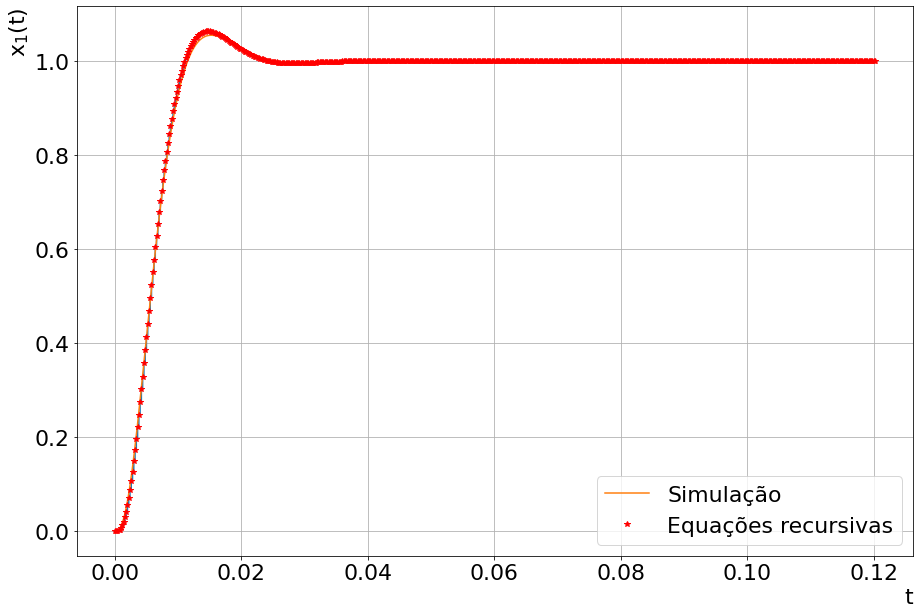

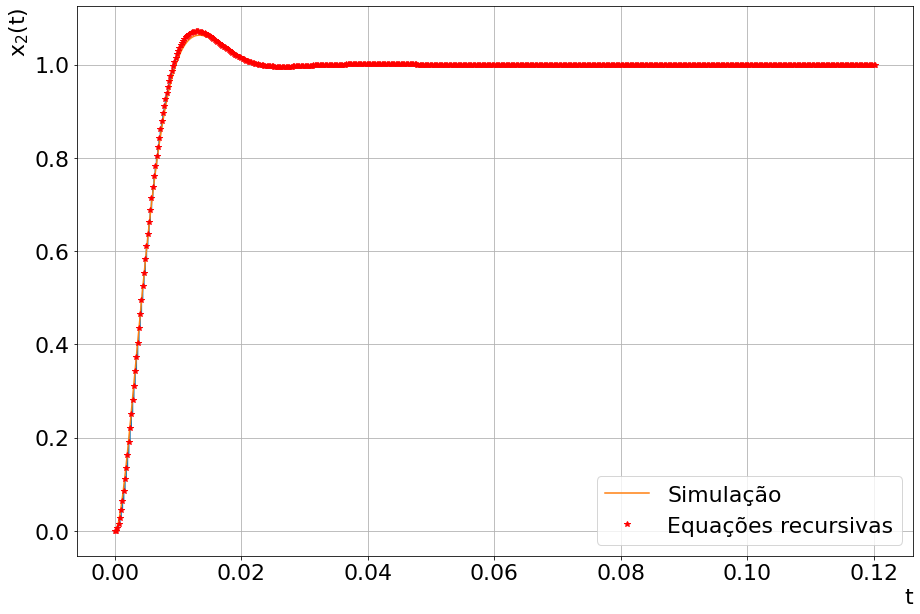

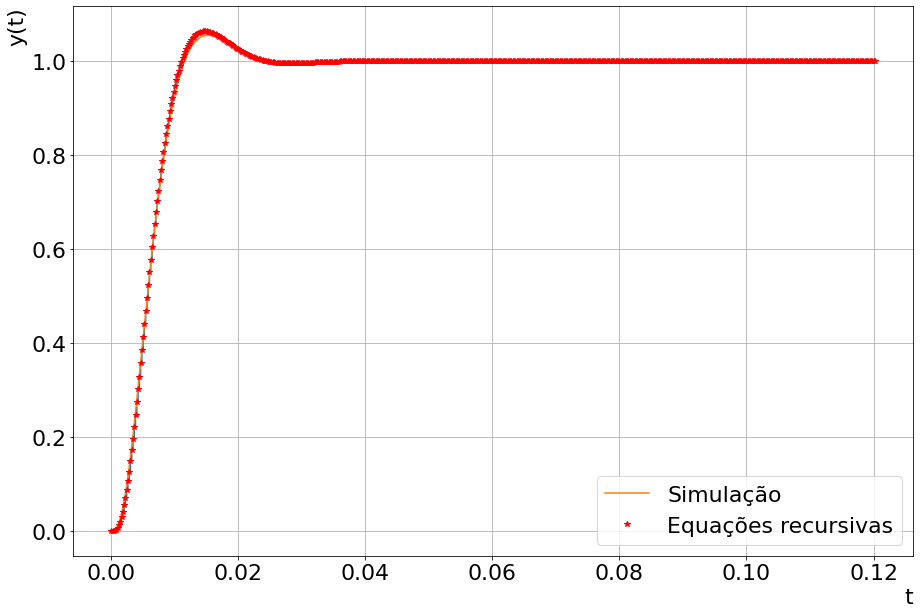

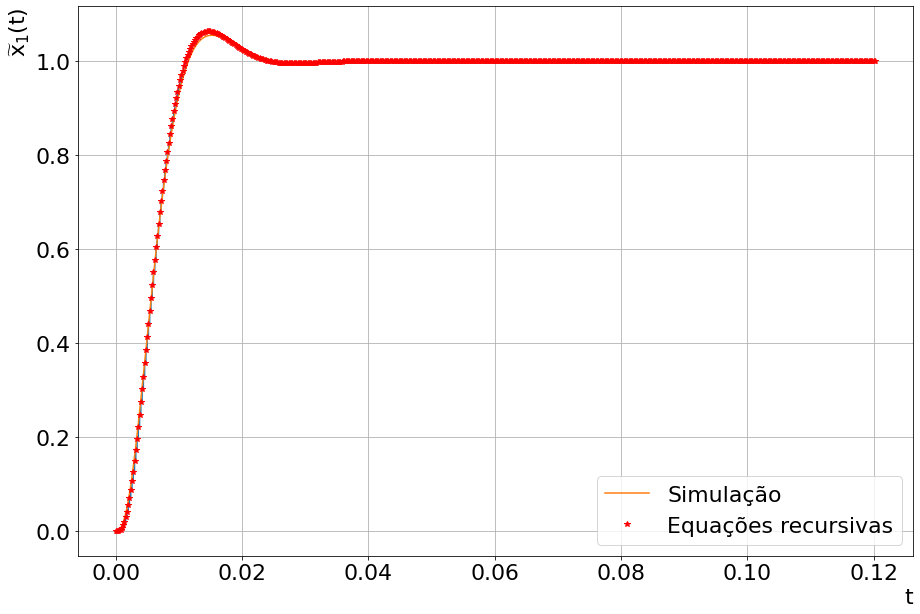

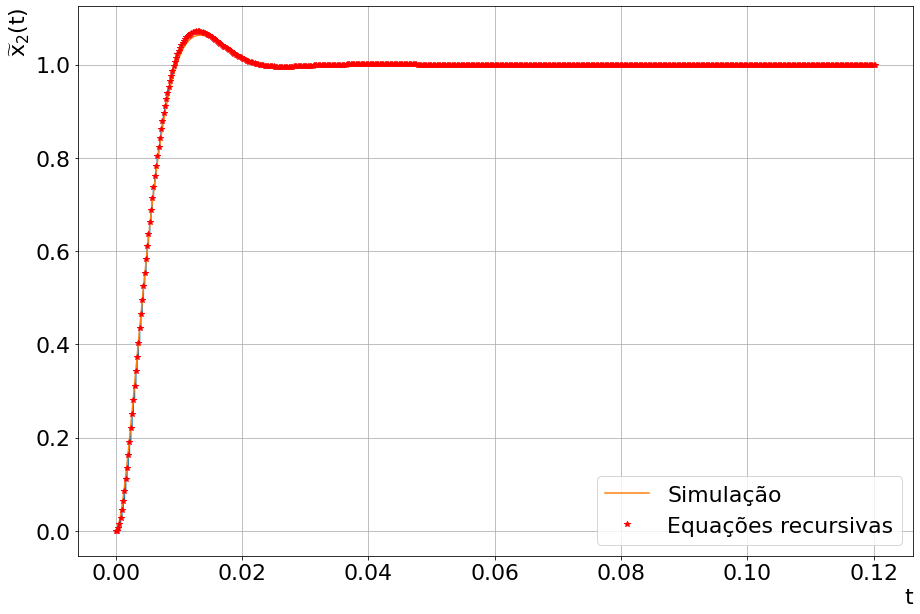

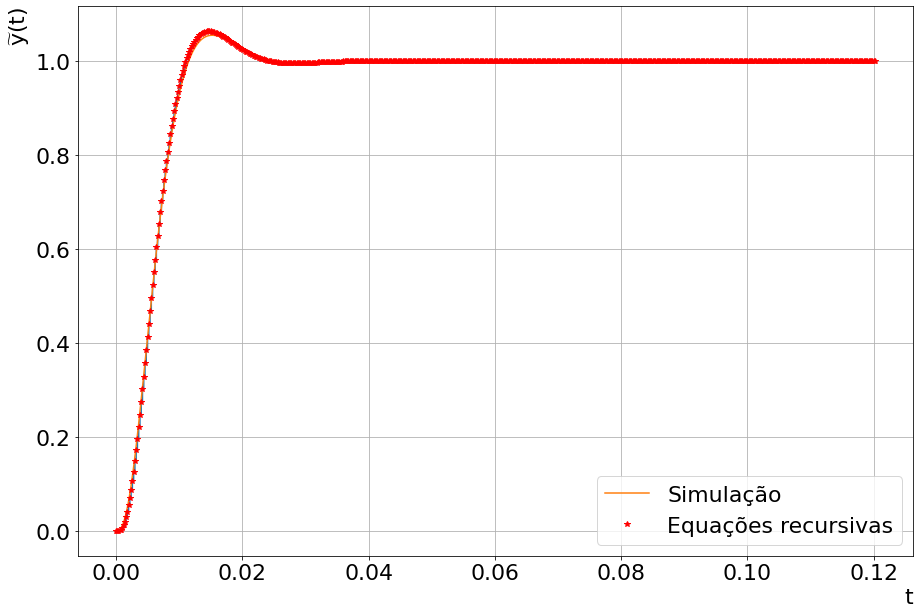

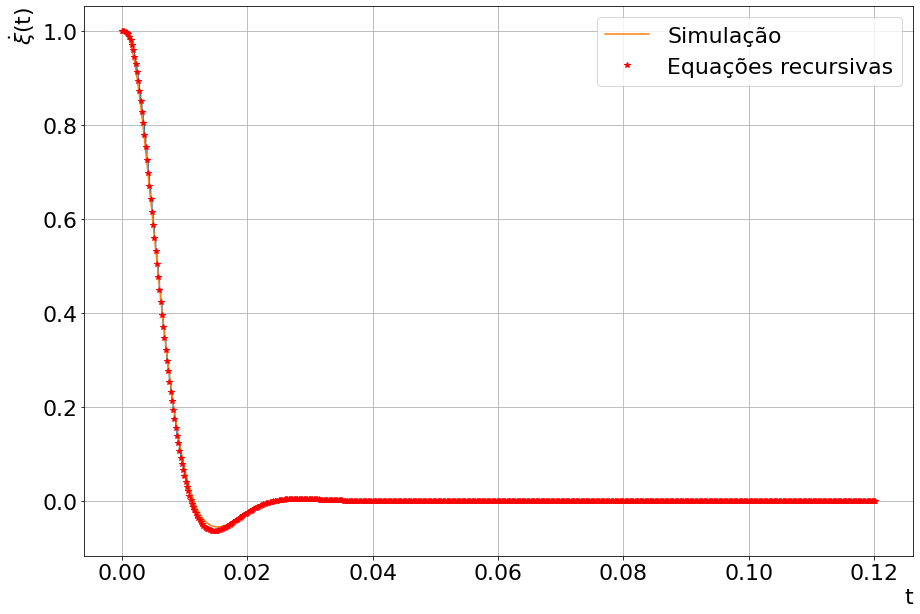

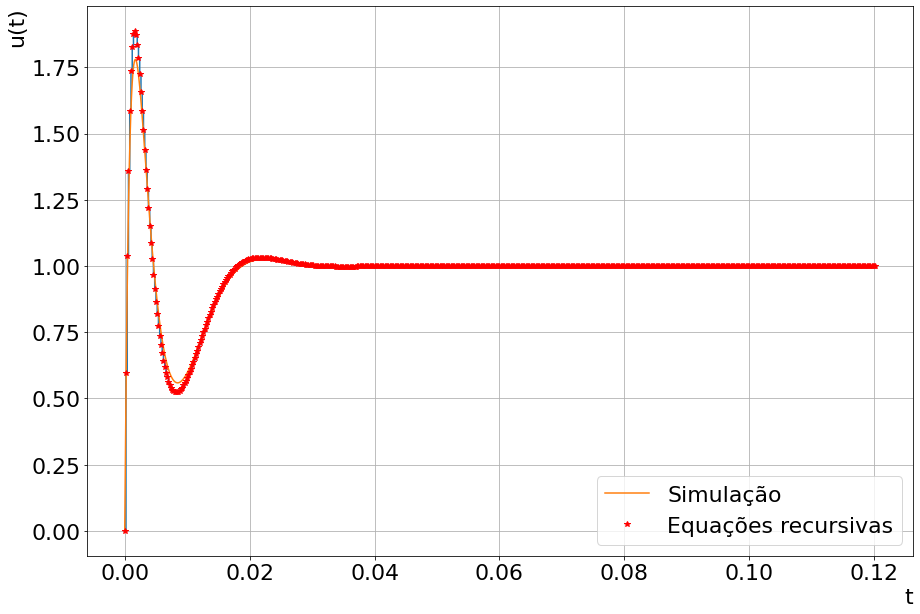

In [28]:
# Simulação do sistema controlado com o observador de estados 'contínuo' e discreto com amplitude de 1,0 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema expandido.

sys = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0], [0], [0]]);

# Simulação do sistema expandido.

t = np.linspace(0, 120e-3, 1000);
R = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, R, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];
X1d = X[:,3];
X1e = X[:,4];

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)

T = 2e-4;
tfinal = 120e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
r = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x1e = np.zeros_like(k);
x2e = np.zeros_like(k);
qsi = np.zeros_like(k);
u = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x1e_ponto = np.zeros_like(k);
x2e_ponto = np.zeros_like(k);
erro = np.zeros_like(k);
y = np.zeros_like(k);
ye = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x1e[0] = x0[3];  #  para k = 0
x2e[0] = x0[4];  #  para k = 0
u[0] = -(K[0,0]*x1e[0]+K[0,1]*x2e[0])+ki*qsi[0];
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x1e_ponto[0] = 0;  #  para k = 0
x2e_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
ye[0] = C[0,0]*x1e[0]+C[0,1]*x2e[0]+D*u[0];  #  para k = 0
erro[0] = r[0]-y[0];  #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x1e[j] = T*x1e_ponto[j-1]+x1e[j-1];
    x2e[j] = T*x2e_ponto[j-1]+x2e[j-1];
    qsi[j] = T*erro[j-1]+qsi[j-1];
    
    # Equação da diferença do sinal de controle:
    
    u[j] = -(K[0,0]*x1e[j]+K[0,1]*x2e[j])+ki*qsi[j];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
    ye[j] = C[0,0]*x1e[j]+C[0,1]*x2e[j]+D*u[j];
    
    # Equação diferencial do erro: Eponto=R-Y
    
    erro[j] = r[j]-y[j];
    
    # Equação diferencial de estados aproximados:  Xeponto=A*Xe+B*U+Ke*(Y-Ye)
    
    x1e_ponto[j] = A[0,0]*x1e[j]+A[0,1]*x2e[j]+B[0]*u[j]+Ke[0,0]*(y[j]-ye[j]);  
    x2e_ponto[j] = A[1,0]*x1e[j]+A[1,1]*x2e[j]+B[1]*u[j]+Ke[1,0]*(y[j]-ye[j]);
    
# Equação do sinal de controle 'contínuo':

U = np.zeros_like(t);
for j in range(len(t)):
    U[j] = -(K[0,0]*X1d[j]+K[0,1]*X1e[j])+ki*X1c[j];

# Equação da saída aproximada:    

Ye = np.zeros_like(t);
for j in range(len(t)):
    Ye[j] = C[0,0]*X1d[j]+C[0,1]*X1e[j]+D*U[j];
    
# Equação do erro do sistema 'contínuo':    

E = np.zeros_like(t);
for j in range(len(t)):
    E[j] = R[j] - Y[j];
    
# Comportamento do estado x1.

plt.figure();

plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2.

plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y.

plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y, label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x1e.

plt.figure();
plt.plot(k*T, x1e, ds='steps-post');
plt.plot(t, X1d, label='Simulação');
plt.plot(k*T, x1e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x2e.

plt.figure();
plt.plot(k*T, x2e, ds='steps-post');
plt.plot(t, X1e, label='Simulação');
plt.plot(k*T, x2e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída ye.

plt.figure();
plt.plot(k*T, ye, ds='steps-post');
plt.plot(t, Ye, label='Simulação');
plt.plot(k*T, ye, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{y}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do erro:                       
plt.figure();
plt.plot(k*T, erro, ds='steps-post');
plt.plot(t, E, label='Simulação');
plt.plot(k*T, erro, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\\dot{\\xi}$(t)");
plt.legend(loc='upper right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da ação de controle:                       
plt.figure();
plt.plot(k*T, u, ds='steps-post');
plt.plot(t, U, label='Simulação');
plt.plot(k*T, u, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("u(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

In [29]:
# Especificações da simulação do sistema controlado em conjunto de um observador de estados para um degrau unitário:

# Tempo de acomodação de 5% para resposta 'contínua':

ts = [];

ts.append(settling_time(Y, t, 0.05));
ts.append(settling_time(Ye, t, 0.05));

# Tempo de acomodação de 5% para resposta discreta:

ts.append(settling_time(y, T*k, 0.05));
ts.append(settling_time(ye, T*k, 0.05));

display(Markdown('## Especificações da simulação do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Ye)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(E[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(U)).replace('.',',')+' \, V \ até \ '+
              str(max(U)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[2]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(ye)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[3]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(erro[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(u)).replace('.',',')+' \, V \ até \ '+
              str(max(u)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações do sistema desejado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(2*NP).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% desejado:'));
display(Latex('$ t_{s5\%} = '+str(NT*1e-3).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));
display(Markdown('### Variação máxima do sinal de controle desejada:'));
display(Latex('$u(t) \ \mathrm{de \ 0 \, V \ até \ 3 \, V}$'));

## Especificações da simulação do sistema controlado para um degrau unitário:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações do sistema desejado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% desejado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle desejada:

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau de 1,5 V do sistema controlado por servossistema em conjunto de um observador de estados:

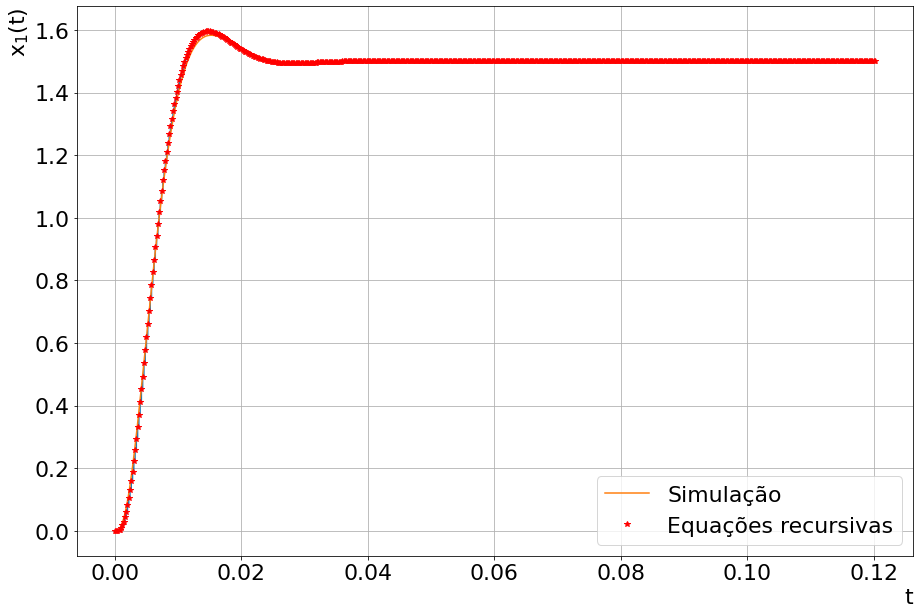

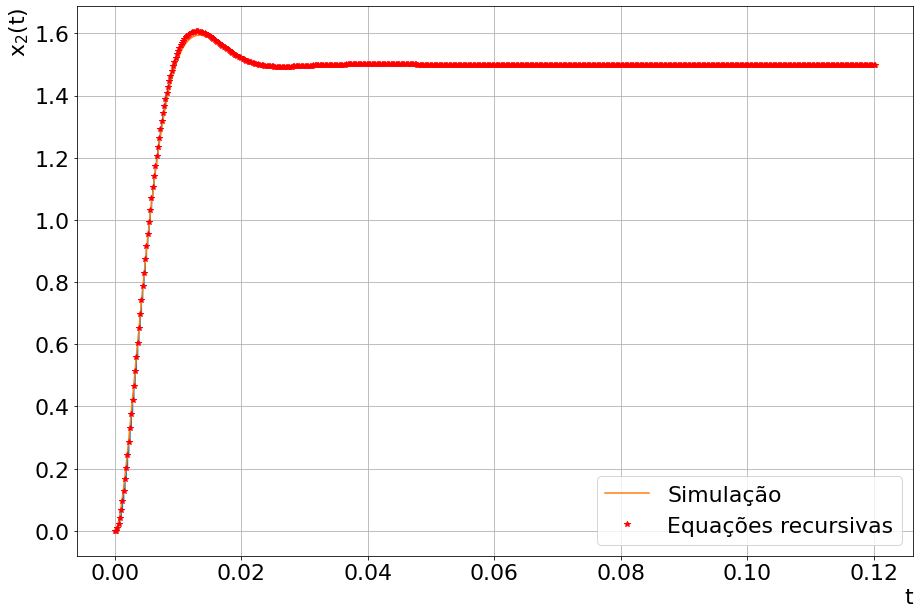

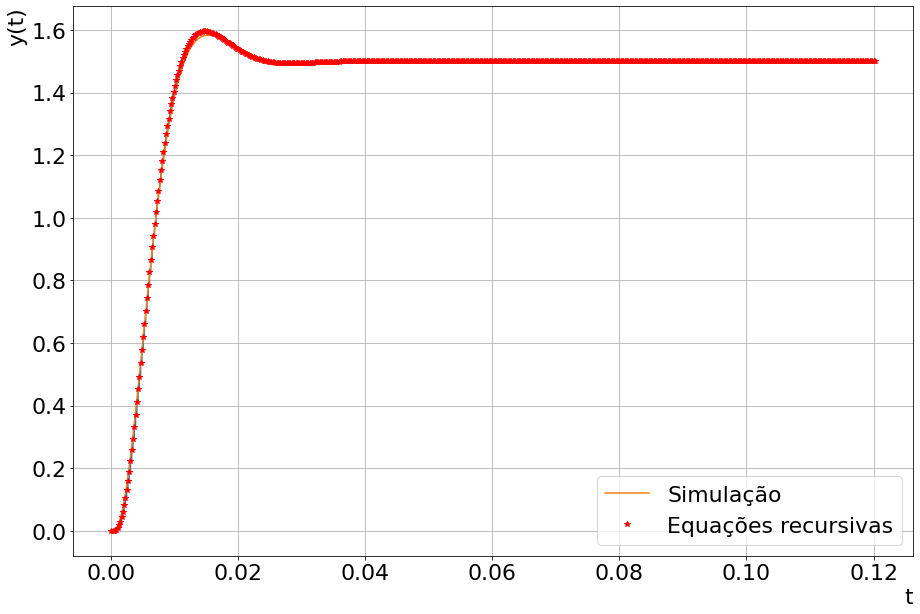

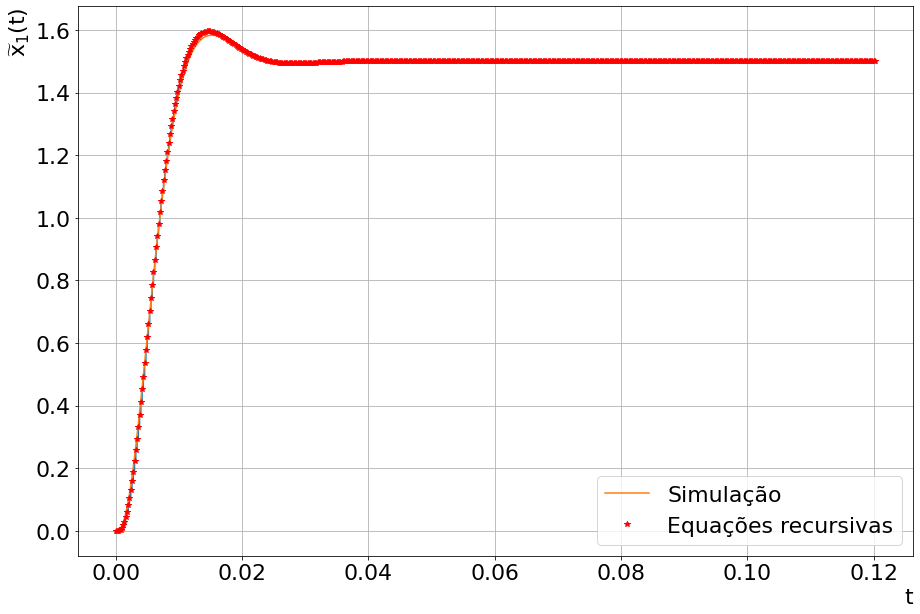

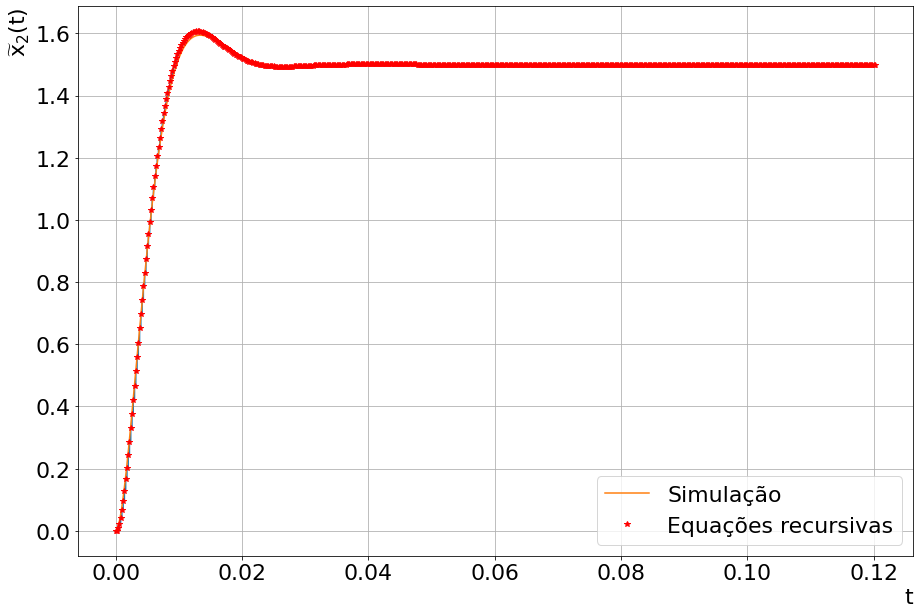

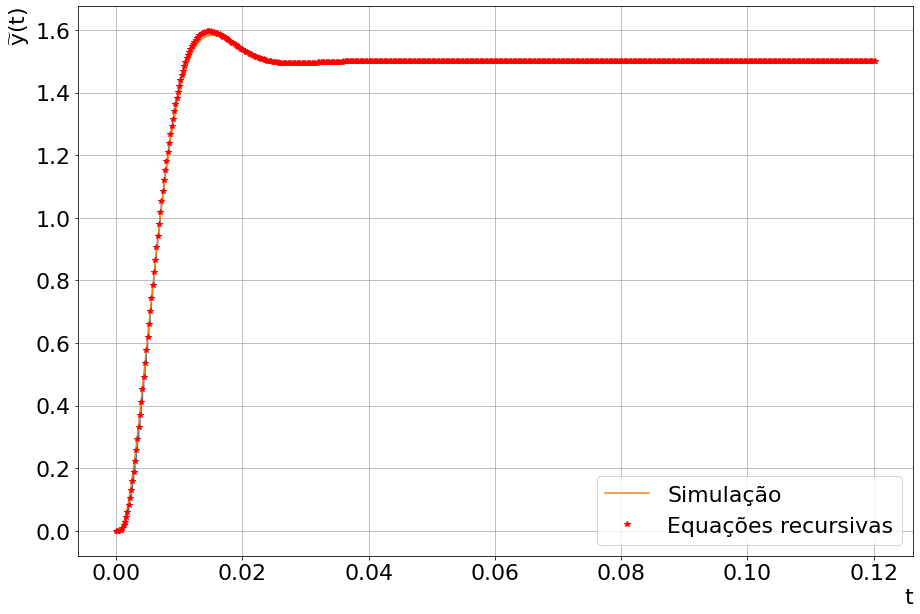

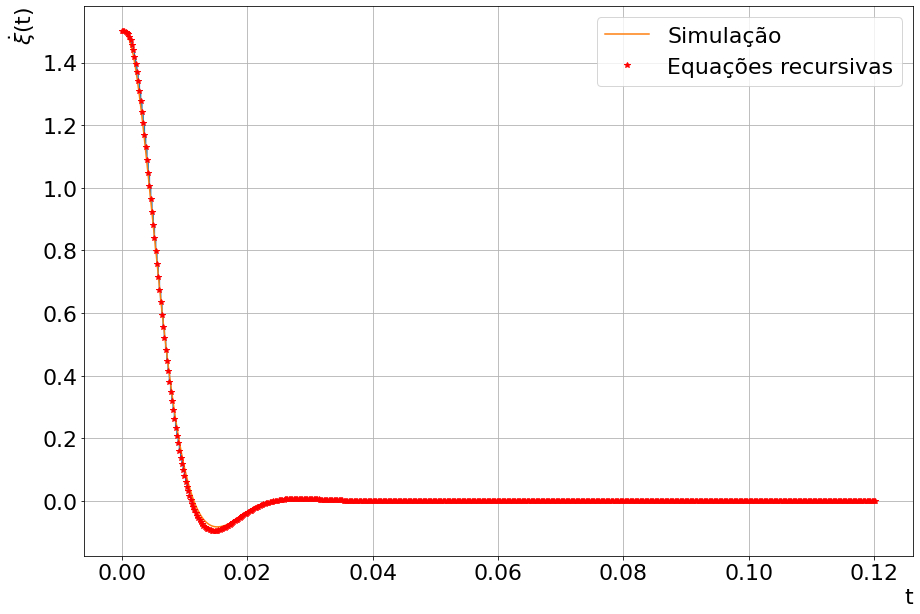

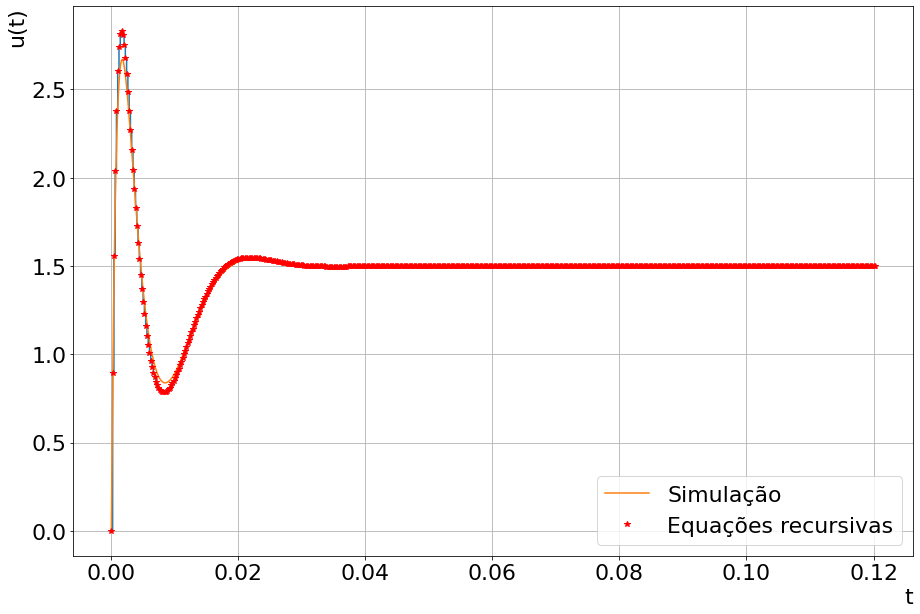

In [30]:
# Simulação do sistema controlado com o observador de estados 'contínuo' e discreto com amplitude de 1,5 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.5;

# Sistema expandido.

sys = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0], [0], [0]]);

# Simulação do sistema expandido.

t = np.linspace(0, 120e-3, 1000);
R = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, R, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];
X1d = X[:,3];
X1e = X[:,4];

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)

T = 2e-4;
tfinal = 120e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
r = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x1e = np.zeros_like(k);
x2e = np.zeros_like(k);
qsi = np.zeros_like(k);
u = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x1e_ponto = np.zeros_like(k);
x2e_ponto = np.zeros_like(k);
erro = np.zeros_like(k);
y = np.zeros_like(k);
ye = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x1e[0] = x0[3];  #  para k = 0
x2e[0] = x0[4];  #  para k = 0
qsi[0] = x0[2];  #  para k = 0
u[0] = -(K[0,0]*x1e[0]+K[0,1]*x2e[0])+ki*qsi[0];
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x1e_ponto[0] = 0;  #  para k = 0
x2e_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
ye[0] = C[0,0]*x1e[0]+C[0,1]*x2e[0]+D*u[0];  #  para k = 0
erro[0] = r[0]-y[0];  #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x1e[j] = T*x1e_ponto[j-1]+x1e[j-1];
    x2e[j] = T*x2e_ponto[j-1]+x2e[j-1];
    qsi[j] = T*erro[j-1]+qsi[j-1];
    
    # Equação da diferença do sinal de controle:
    
    u[j] = -(K[0,0]*x1e[j]+K[0,1]*x2e[j])+ki*qsi[j];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
    ye[j] = C[0,0]*x1e[j]+C[0,1]*x2e[j]+D*u[j];
    
    # Equação diferencial do erro: Eponto=R-Y
    
    erro[j] = r[j]-y[j];
    
    # Equação diferencial de estados aproximados:  Xeponto=A*Xe+B*U+Ke*(Y-Ye)
    
    x1e_ponto[j] = A[0,0]*x1e[j]+A[0,1]*x2e[j]+B[0]*u[j]+Ke[0,0]*(y[j]-ye[j]);  
    x2e_ponto[j] = A[1,0]*x1e[j]+A[1,1]*x2e[j]+B[1]*u[j]+Ke[1,0]*(y[j]-ye[j]);
    
# Equação do sinal de controle 'contínuo':

U = np.zeros_like(t);
for j in range(len(t)):
    U[j] = -(K[0,0]*X1d[j]+K[0,1]*X1e[j])+ki*X1c[j];

# Equação da saída aproximada:    

Ye = np.zeros_like(t);
for j in range(len(t)):
    Ye[j] = C[0,0]*X1d[j]+C[0,1]*X1e[j]+D*U[j];
    
# Equação do erro do sistema 'contínuo':    

E = np.zeros_like(t);
for j in range(len(t)):
    E[j] = R[j] - Y[j];
    
# Comportamento do estado x1.

plt.figure();

plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2.

plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y.

plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y, label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x1e.

plt.figure();
plt.plot(k*T, x1e, ds='steps-post');
plt.plot(t, X1d, label='Simulação');
plt.plot(k*T, x1e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x2e.

plt.figure();
plt.plot(k*T, x2e, ds='steps-post');
plt.plot(t, X1e, label='Simulação');
plt.plot(k*T, x2e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída ye.

plt.figure();
plt.plot(k*T, ye, ds='steps-post');
plt.plot(t, Ye, label='Simulação');
plt.plot(k*T, ye, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{y}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do erro:                       
plt.figure();
plt.plot(k*T, erro, ds='steps-post');
plt.plot(t, E, label='Simulação');
plt.plot(k*T, erro, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\\dot{\\xi}$(t)");
plt.legend(loc='upper right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da ação de controle:                       
plt.figure();
plt.plot(k*T, u, ds='steps-post');
plt.plot(t, U, label='Simulação');
plt.plot(k*T, u, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("u(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

In [31]:
# Especificações da simulação do sistema controlado em conjunto de um observador de estados para um degrau de 1,5 V:

# Tempo de acomodação de 5% para resposta 'contínua':

ts = [];

ts.append(settling_time(Y, t, 0.05));
ts.append(settling_time(Ye, t, 0.05));

# Tempo de acomodação de 5% para resposta discreta:

ts.append(settling_time(y, T*k, 0.05));
ts.append(settling_time(ye, T*k, 0.05));

display(Markdown('## Especificações da simulação do sistema controlado para um degrau de 1,5 V:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Ye)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(E[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(U)).replace('.',',')+' \, V \ até \ '+
              str(max(U)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações da simulação por equações recursivas do sistema controlado para um degrau de 1,5 V:'));
display(Markdown('### Sobressinal da saída original:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída original:'));
display(Latex('$ t_{s5\%} = '+str(ts[2]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Sobressinal da saída aproximada:'));
display(Latex('$ M_{p\%} = '+str(overshoot(ye)).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% da saída aproximada:'));
display(Latex('$ t_{s5\%} = '+str(ts[3]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(erro[-1]).replace('.',',')+'$'));
display(Markdown('### Variação máxima do sinal de controle obtida:'));
display(Latex('$u(t) \ \mathrm{de \ '+str(min(u)).replace('.',',')+' \, V \ até \ '+
              str(max(u)).replace('.',',')+' \, V}$'));
display(Markdown('## Especificações do sistema desejado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(2*NP).replace('.',',')+'\, \%$'));
display(Markdown('### Atraso de acomodação de 5% desejado:'));
display(Latex('$ t_{s5\%} = '+str(NT*1e-3).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));
display(Markdown('### Variação máxima do sinal de controle desejada:'));
display(Latex('$u(t) \ \mathrm{de \ 0 \, V \ até \ 3 \, V}$'));

## Especificações da simulação do sistema controlado para um degrau de 1,5 V:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações da simulação por equações recursivas do sistema controlado para um degrau de 1,5 V:

### Sobressinal da saída original:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída original:

<IPython.core.display.Latex object>

### Sobressinal da saída aproximada:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% da saída aproximada:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle obtida:

<IPython.core.display.Latex object>

## Especificações do sistema desejado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Atraso de acomodação de 5% desejado:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

### Variação máxima do sinal de controle desejada:

<IPython.core.display.Latex object>